In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

%tensorflow_version 1.x
import tensorflow as tf
from keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
# if using colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Getting to know the data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/__MGR/waterlevel_1989_2018.csv', index_col=0)
#df = pd.read_csv('waterlevel_1989_2018.csv', index_col=0)

In [ ]:
df.index = pd.DatetimeIndex(df.index)
df

lvl
1989-01-01 01:00:00   6.0
1989-01-01 02:00:00  18.0
1989-01-01 03:00:00  27.0
1989-01-01 04:00:00  31.0
1989-01-01 05:00:00  34.0
...                   ...
2018-12-31 20:00:00  11.0
2018-12-31 21:00:00   9.0
2018-12-31 22:00:00   3.0
2018-12-31 23:00:00  -3.0
2019-01-01 00:00:00  -7.0

[262968 rows x 1 columns]

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

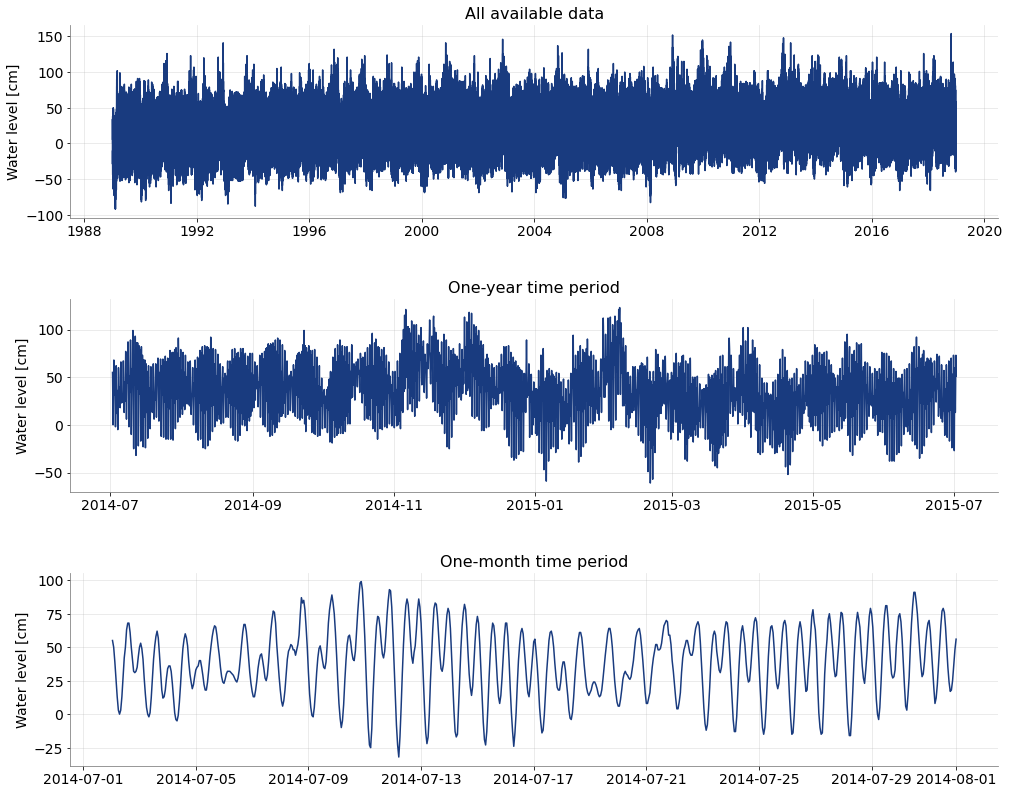

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15, 12))
ax[0].plot(df, color='#193B7F')
ax[0].set_title('All available data')
ax[1].plot(df[223512:223512+365*24], color='#193B7F')
ax[1].set_title('One-year time period')
ax[2].plot(df[223512:223512+30*24], color='#193B7F')
ax[2].set_title('One-month time period')

for ax in [ax[0], ax[1], ax[2]]:
    ax.set_ylabel('Water level [cm]')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color(None)
    ax.spines['left'].set_color('0.5')
    ax.spines['right'].set_color(None)
    ax.grid(alpha=0.3)
fig.tight_layout(pad=3.0)
#plt.savefig('/content/drive/My Drive/__MGR/original_data.pdf')
plt.show()

### Linear trend


In [ ]:
from sklearn.linear_model import LinearRegression

time = np.arange(0, len(df))
lvl = df['lvl']
reg = LinearRegression().fit(time.reshape(-1, 1), lvl)

In [ ]:
reg.coef_

array([6.86884074e-05])

There's an increasing linear trend.

### Seasonality

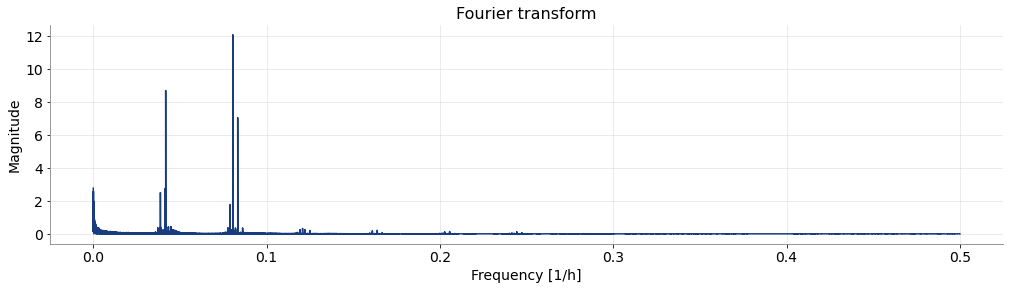

most significant periods obtained - in hours:
 [    12.42055545     23.93446801     12.         262968.
     24.06589183   8765.6            25.8191458  131484.
     11.967234     4382.8            12.65851545  37566.85714286
     12.42114213   7107.24324324  21914.          14609.33333333
     23.93011193   1429.17391304   4108.875          12.41996883
  32871.           5366.69387755   7513.37142857   5843.73333333
     12.42172886  65742.           1891.85611511   4045.66153846
  17531.2          4533.93103448  23906.18181818   1163.57522124
  13148.4            24.           7734.35294118     12.65790614
   2797.53191489   2954.69662921   1511.31034483]
- in days:
 [    0.51752314     0.9972695      0.5        10957.
     1.00274549   365.23333333     1.07579774  5478.5
     0.49863475   182.61666667     0.52743814  1565.28571429
     0.51754759   296.13513514   913.08333333   608.72222222
     0.997088      59.54891304   171.203125       0.5174987
  1369.625        223.6122449    

In [ ]:
fft3 = np.fft.rfft(lvl) / len(lvl) #* 2  #normalized (and *2 because using rfft we have just a half of the power)
freqs = np.fft.rfftfreq(len(lvl), 1)

fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(freqs[1:], np.abs(fft3)[1:], color='#193B7F')
ax.set_title('Fourier transform')
ax.set_xlabel('Frequency [1/h]')
ax.set_ylabel('Magnitude')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
fig.tight_layout(pad=3.0)
#plt.savefig('/content/drive/My Drive/__MGR/original_data_fft.pdf')
plt.show()

arg_top = np.abs(fft3).argsort()[-40:-1][::-1]
np.set_printoptions(suppress=True)
print('most significant periods obtained - in hours:\n', 1 / freqs[arg_top])
print('- in days:\n', 1 / freqs[arg_top] / 24)
print('indices:\n', arg_top)


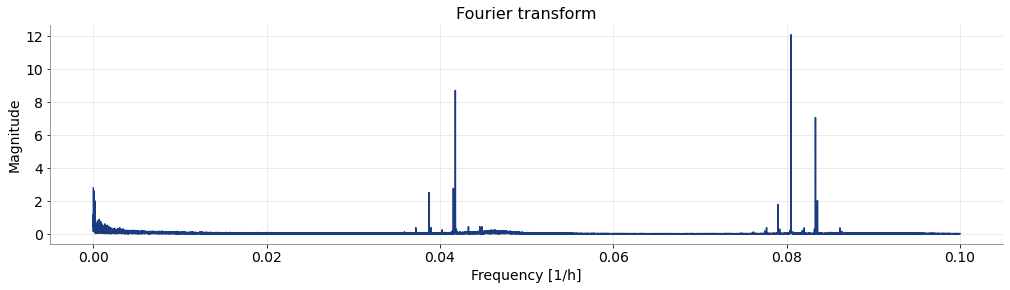

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(freqs[1:round(len(freqs)/5)], np.abs(fft3)[1:round(len(freqs)/5)], color='#193B7F')
ax.set_title('Fourier transform')
ax.set_xlabel('Frequency [1/h]')
ax.set_ylabel('Magnitude')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
fig.tight_layout(pad=3.0)
plt.savefig('/content/drive/My Drive/__MGR/original_data_fft_zoom.pdf')
plt.show()

Many seasonalities discovered (especially around 12h, 24h, 1 year, half a year)

# Fitting the model to data

## Functions

In [ ]:
def create_dataset(dataset, look_back=48, pred_window=12):
    'function to create windows for training'
    'necessary to control time series length in order to obtain full sequences'
    dataX, dataY = [], []
    for i in np.arange(0, len(dataset)-look_back-pred_window, pred_window):   # this -pred_window cuts the last window from the data :(
        a = dataset[i:(i+look_back)]                                          # my bad, but im too lazy to change the rest of the code
        dataX.append(a.reshape(-1,1))
        dataY.append(dataset[(i + look_back):(i + look_back + pred_window)])
    return np.array(dataX), np.array(dataY)

def create_dataset1(dataset, look_back=48, pred_window=12):
    'function to create windows for training'
    'necessary to control time series length in order to obtain full sequences'
    dataX, dataY = [], []
    for i in np.arange(0, len(dataset)-look_back, pred_window):               # this one is good!
        a = dataset[i:(i+look_back)]
        dataX.append(a.reshape(-1,1))
        dataY.append(dataset[(i + look_back):(i + look_back + pred_window)])
    return np.array(dataX), np.array(dataY)

In [ ]:
def accuracy(true_test, prediction):
    'function to analyze the results with plots, error measures and frequency check'
        
    window = true_test.shape[1]
    error = true_test.flatten() - prediction.flatten()
    
    fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(18, 4))
    ax1.plot(true_test.flatten()[0:window], color='#193B7F')
    ax1.plot(prediction.flatten()[0:window], color='red')
    #ax1.set_title('One prediction window ahead') 
    ax1.set_title('12 hours ahead') 
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Value [cm]')
    ax1.legend(['True values', 'Prediction'], loc='lower right')
    
    ax2.scatter(true_test.flatten()[0:window], prediction[0:window], color='#193B7F')
    ax2.plot(true_test.flatten()[0:window], true_test.flatten()[0:window], color='k')
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted vaue')

    for ax in [ax1, ax2]:
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color(None)
        ax.spines['left'].set_color('0.5')
        ax.spines['right'].set_color(None)
        ax.grid(alpha=0.3)
    fig.tight_layout(pad=3.0)
    plt.savefig('/content/drive/My Drive/__MGR/accuracy1.pdf')
    plt.show()
    
    mse = np.mean(error[0:window] ** 2)
    print('Mean squared error for first single window prediction: ', mse)

    
    fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(18, 4))
    ax1.plot(true_test.flatten()[0:720], color='#193B7F')
    ax1.plot(prediction.flatten()[0:720], color='red')
    ax1.set_title('One month ahead') 
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Value [cm]')
    ax1.legend(['True values', 'Prediction'], loc='lower right')
    
    ax2.scatter(true_test.flatten()[0:720], prediction[0:720], color='#193B7F')
    ax2.plot(true_test.flatten()[0:720], true_test.flatten()[0:720], color='k')
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted vaue')

    for ax in [ax1, ax2]:
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color(None)
        ax.spines['left'].set_color('0.5')
        ax.spines['right'].set_color(None)
        ax.grid(alpha=0.3)
    fig.tight_layout(pad=3.0)
    plt.savefig('/content/drive/My Drive/__MGR/accuracy2.pdf')
    plt.show()
    
    mse = np.mean(error[0:720] ** 2)
    print('Mean squared error for one month prediction: ', mse)
    
    
    fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(18, 4))
    ax1.plot(true_test.flatten()[0:8760], color='#193B7F')
    ax1.plot(prediction.flatten()[0:8760], color='red')
    ax1.set_title('One year ahead') 
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Value [cm]')
    ax1.legend(['True values', 'Prediction'], loc='lower right')
    
    ax2.scatter(true_test.flatten()[0:8760], prediction[0:8760], color='#193B7F')
    ax2.plot(true_test.flatten()[0:8760], true_test.flatten()[0:8760], color='k')
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted vaue')
    
    for ax in [ax1, ax2]:
        ax.spines['bottom'].set_color('0.5')
        ax.spines['top'].set_color(None)
        ax.spines['left'].set_color('0.5')
        ax.spines['right'].set_color(None)
        ax.grid(alpha=0.3)
    fig.tight_layout(pad=3.0)
    plt.savefig('/content/drive/My Drive/__MGR/accuracy3.pdf')
    plt.show()
    
    mse = np.mean(error[0:8760] ** 2)
    print('Mean squared error for one year prediction: ', mse)
    
    
    fft3 = np.fft.rfft(prediction) / len(prediction) 
    freqs = np.fft.rfftfreq(len(prediction), 1)

    fig, ax = plt.subplots(1,1, figsize=(15, 5))
    ax.plot(freqs[1:], np.abs(fft3)[1:], color='#193B7F')
    ax.set_xlabel('Frequency [1/hour]')
    ax.set_ylabel('Magnitude')
    ax.set_title('Fourier transform of predicted values')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color(None)
    ax.spines['left'].set_color('0.5')
    ax.spines['right'].set_color(None)
    ax.grid(alpha=0.3)
    fig.tight_layout(pad=3.0)
    #plt.savefig('/content/drive/My Drive/__MGR/pred_fft.pdf')
    plt.show()

    arg_top = np.abs(fft3).argsort()[-25:-1][::-1]
    np.set_printoptions(suppress=True)
    print('most significant periods obtained - in hours:\n', 1 / freqs[arg_top])
    print('- in days:\n', 1 / freqs[arg_top] / 24)
    print('indices:\n', arg_top)

    

In [ ]:
def see_between_quantiles(Y_test, predictions_matrix, quantile, caption):
    'quantile analysis, if you set the upper quantile=0.95, then you analyze 90% quantile range, since the lower quantile is set to 0.05'

    lower_quantiles = np.quantile(predictions_matrix, round(1.00-quantile,2), axis=0)
    upper_quantiles = np.quantile(predictions_matrix, quantile, axis=0)
    pred_window = Y_test.shape[1]

    fig, ax = plt.subplots(3, 1, figsize=(15, 12))
    windows = [24, 720, 720*3]
    cap = ['One day ahead', 'One month ahead', 'Three months ahead']

    for i in range(3):
        ax[i].plot(Y_test.flatten()[0:windows[i]], color='#193B7F')
        ax[i].plot(lower_quantiles[0:windows[i]], color='red')
        ax[i].plot(upper_quantiles[0:windows[i]], color='red')
        ax[i].set_title(cap[i]) 
        ax[i].set_xlabel('Time [h]')
        ax[i].set_ylabel('Value [cm]')
        ax[i].legend(['True values', 'Quantiles {low} and {up}\nof prediction'.format(low=round(1-quantile,2), up=quantile)], loc='lower right')
        ax[i].spines['bottom'].set_color('0.5')
        ax[i].spines['top'].set_color(None)
        ax[i].spines['left'].set_color('0.5')
        ax[i].spines['right'].set_color(None)
        ax[i].grid(alpha=0.3)

    fig.tight_layout(pad=3.0)
    plt.savefig('/content/drive/My Drive/__MGR/between_quantiles_{cap}.pdf'.format(cap=caption))
    plt.show()

    print('What part of real values lies between quantile lines:')
    # for one pred window:
    end = pred_window
    print('In the first {pred_window} hours (prediction window): '.format(pred_window=pred_window), np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    end = 12
    print('In the first 12 hours: ', np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    end = 24
    print('In the first 24 hours: ', np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    end = 48
    print('In the first 48 hours: ', np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    # for one month pred:
    end = 720
    print('For the first month: ', np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    # for one year pred:
    end = 8760
    print('For the first year: ', np.mean((lower_quantiles[:end] <= Y_test.flatten()[:end]) & (Y_test.flatten()[:end] <= upper_quantiles[:end])))

    width = upper_quantiles - lower_quantiles
    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    
    ax.plot(width[0:720], color='#193B7F')
    ax.set_title('Width of {q}% prediction range for 1 month ahead'.format(q=round(100*quantile - 100*(1-quantile))))
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Width [cm]')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color(None)
    ax.spines['left'].set_color('0.5')
    ax.spines['right'].set_color(None)
    ax.grid(alpha=0.3)

    fig.tight_layout(pad=3.0)
    plt.show()

    print('Average width of', round(100*quantile - 100*(1-quantile)), '% predinction range:')
    end = pred_window
    print('In the first {pred_window} hours (prediction window): '.format(pred_window=pred_window), np.mean(width[:end]))
    end = 12
    print('In the first 12 hours: ', np.mean(width[:end]))
    end = 24
    print('In the first 24 hours: ', np.mean(width[:end]))
    end = 48
    print('In the first 48 hours: ', np.mean(width[:end]))
    end = 720
    print('For the first month: ', np.mean(width[:end]))
    end = 8760
    print('For the first year: ', np.mean(width[:end]))


## Scaling data and then fitting

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = df.copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled['lvl'] = scaler.fit_transform(df_scaled[['lvl']])
df_scaled

lvl
1989-01-01 01:00:00 -2.032520e-01
1989-01-01 02:00:00 -1.056911e-01
1989-01-01 03:00:00 -3.252033e-02
1989-01-01 04:00:00  1.110223e-16
1989-01-01 05:00:00  2.439024e-02
...                           ...
2018-12-31 20:00:00 -1.626016e-01
2018-12-31 21:00:00 -1.788618e-01
2018-12-31 22:00:00 -2.276423e-01
2018-12-31 23:00:00 -2.764228e-01
2019-01-01 00:00:00 -3.089431e-01

[262968 rows x 1 columns]

#### starting model

In [ ]:
look_back = 48
pred_window = 12
X, Y = create_dataset(np.array(df_scaled['lvl']), look_back=look_back, pred_window=pred_window)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=False)

In [ ]:
# to calculate number of parameters in LSTM layer
n = 48  # number of cells and size of the history h_{t-1}
m = 1    # size of the input x_t
4 * (n * (n + m + 1))

9600

In [ ]:
300/25

12.0

In [ ]:
batch = 64

model_many_epochs = Sequential()
model_many_epochs.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
model_many_epochs.add(LSTM(24, return_sequences=True))
model_many_epochs.add(LSTM(24))
model_many_epochs.add(Dense(pred_window))

model_many_epochs.compile(optimizer='adam', loss='mean_squared_error')
model_many_epochs.summary()

#model_many_epochs.fit(X_train, Y_train, batch_size=batch, epochs=2, validation_data=(X_test, Y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 48)            9600      
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 24)            7008      
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
Total params: 21,612
Trainable params: 21,612
Non-trainable params: 0
_________________________________________________________________


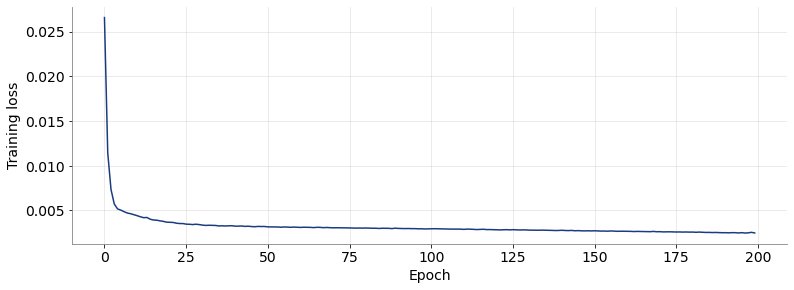

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
ax.plot(model_many_epochs.history.history['loss'], color='#193B7F')
ax.set_ylabel('Training loss')
ax.set_xlabel('Epoch')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
fig.tight_layout(pad=3.0)
#plt.savefig('/content/drive/My Drive/__MGR/loss_epochs.pdf')
#np.savetxt('/content/drive/My Drive/__MGR/training_loss_200ep_64batch.csv'.format(k=k), model_many_epochs.history.history['loss'], delimiter=',', fmt='%10.5f')
plt.show()

In [ ]:
# many optimizers

batch = 64
optim = ['adam', 'Adagrad', 'RMSprop', 'sgd', 'Adadelta', 'Adamax', 'Nadam']
losses_optim = np.zeros((7,70))

for i in range(4,7):
    model_many_epochs = Sequential()
    model_many_epochs.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_many_epochs.add(LSTM(24, return_sequences=True))
    model_many_epochs.add(LSTM(24))
    model_many_epochs.add(Dense(pred_window))

    model_many_epochs.compile(optimizer=optim[i], loss='mean_squared_error')
    model_many_epochs.summary()
    model_many_epochs.fit(X_train, Y_train, batch_size=batch, epochs=70, validation_data=(X_test, Y_test))

    losses_optim[i] = model_many_epochs.history.history['loss']

In [ ]:
for i in range(4,7):
  np.savetxt('/content/drive/My Drive/__MGR/loss_{optim}.csv'.format(optim=optim[i]), losses_optim[i], delimiter=',', fmt='%10.5f')

In [ ]:
for i in range(7):
    losses_optim[i] = np.genfromtxt('/content/drive/My Drive/__MGR/loss_{optim}.csv'.format(optim=optim[i]), delimiter=',')

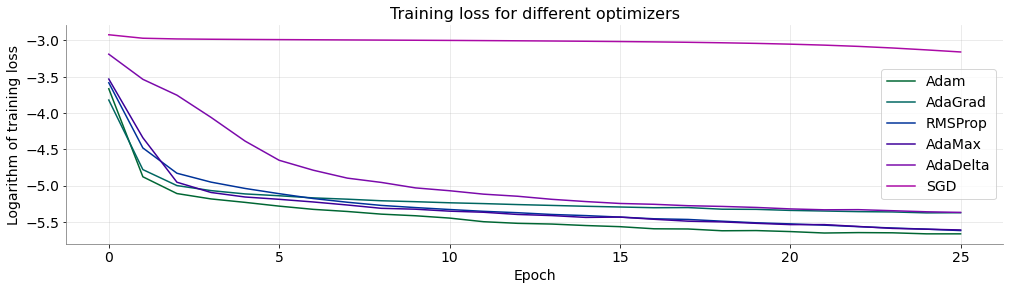

In [ ]:
optim = ['Adam', 'AdaGrad', 'RMSProp', 'SGD', 'AdaDelta', 'AdaMax', 'Nadam']
fig, ax = plt.subplots(1,1, figsize=(15, 5))
cols = ['#006633','#006661','#003399','#AB0AA6','#7B0AAB','#3D0099']
for i in [0,1,2,5,4,3]:
    plt.plot(np.log(losses_optim[i][:26]), color=cols[i])
ax.set_title('Training loss for different optimizers')
ax.set_xlabel('Epoch')
ax.set_ylabel('Logarithm of training loss')
ax.legend(np.array(optim)[[0,1,2,5,4,3]])
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
fig.tight_layout(pad=3.0)
plt.savefig('/content/drive/My Drive/__MGR/loss_optimizers.pdf')
plt.show()

In [ ]:
# producing multiple models and their predictions to see the quantile lines later
batch = 64
 
for k in range(50,60):
    model_12 = Sequential()
    model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(24))
    model_12.add(Dense(pred_window))
 
    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))
 
    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

In [ ]:
scaler.inverse_transform(Y_test)

array([[55., 50., 39., ..., 27., 42., 50.],
       [63., 68., 68., ..., 35., 43., 50.],
       [53., 49., 41., ..., 12., 27., 41.],
       ...,
       [19., 31., 42., ..., 13.,  8.,  1.],
       [ 0.,  0.,  2., ..., -4., -6., -4.],
       [ 0.,  9., 20., ..., 22.,  7., -4.]])

In [ ]:
predictions12_scaled = np.zeros((50,Y_test.shape[0]*Y_test.shape[1]))
for k in range(50):
    predictions12_scaled[k] = scaler.inverse_transform(np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled/{k}.csv'.format(k=k), delimiter=',').reshape(-1, 1)).flatten()

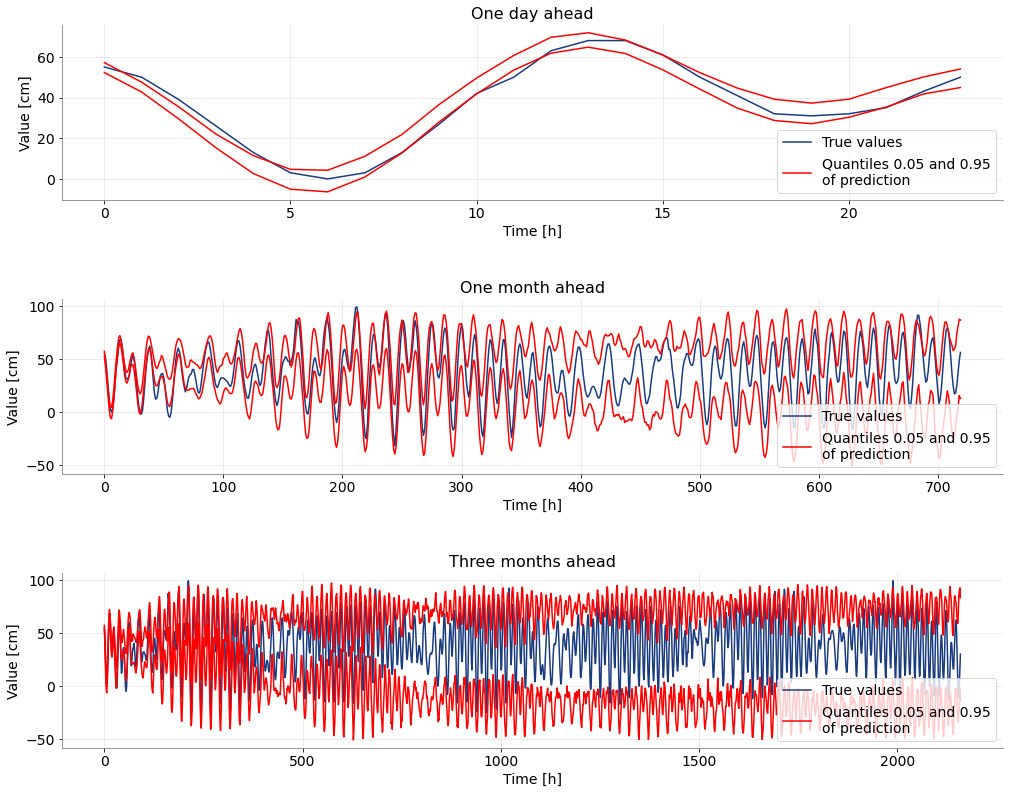

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.5
In the first 12 hours:  0.5
In the first 24 hours:  0.6666666666666666
In the first 48 hours:  0.5416666666666666
For the first month:  0.8888888888888888
For the first year:  0.9140410958904109


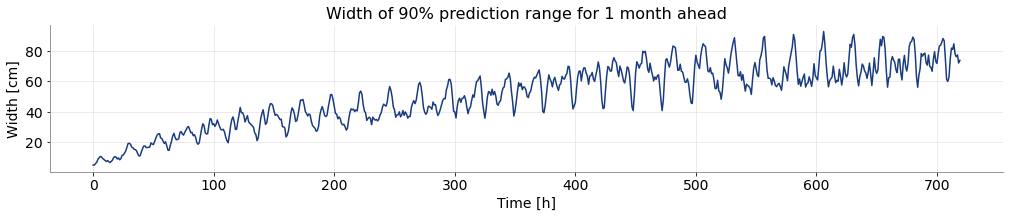

Average width of 90 % predinction range:
In the first 12 hours (prediction window):  7.869852624999999
In the first 12 hours:  7.869852624999999
In the first 24 hours:  8.234888437499999
In the first 48 hours:  11.717445093749996
For the first month:  50.85973799791665
For the first year:  91.97796963356161


In [ ]:
see_between_quantiles(scaler.inverse_transform(Y_test), predictions12_scaled, 0.95, 'starting_model')

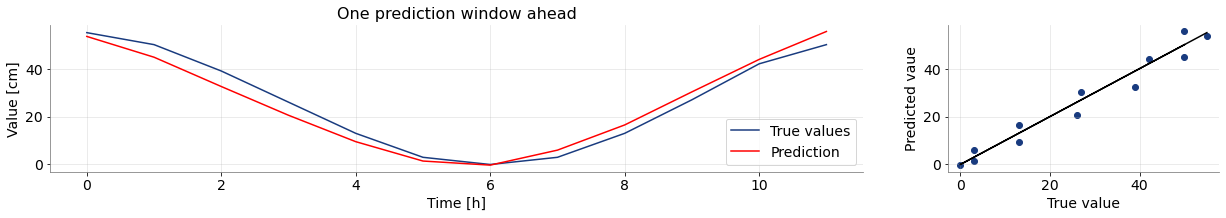

Mean squared error for first single window prediction:  15.157973223200012


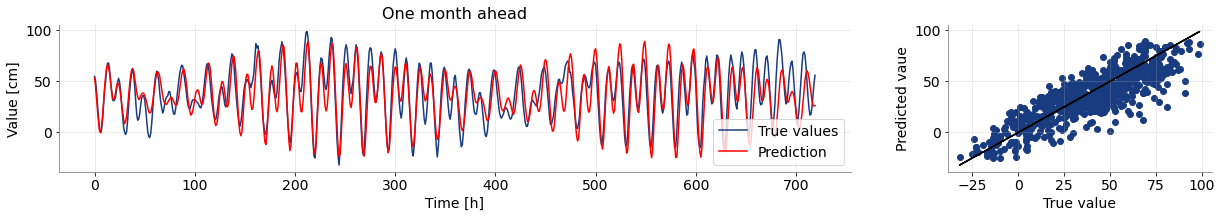

Mean squared error for one month prediction:  204.1396283037853


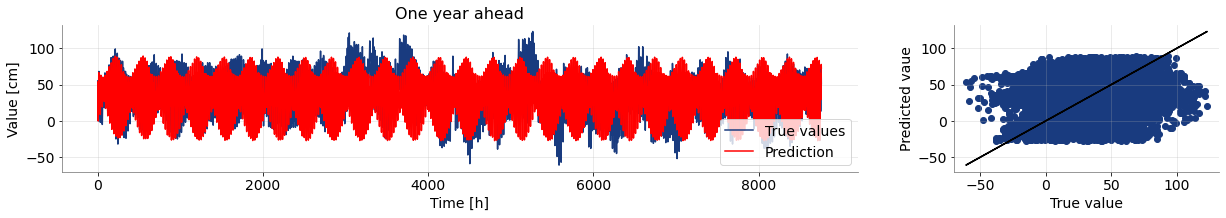

Mean squared error for one year prediction:  1200.2733176598294


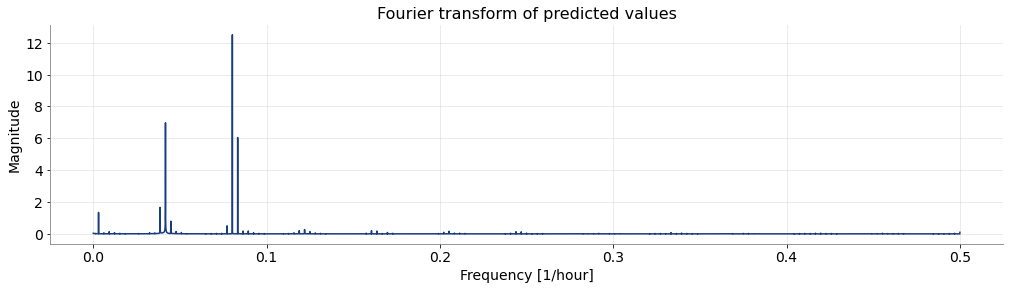

most significant periods obtained - in hours:
 [ 12.45862287  23.99270073  24.00730371  12.          23.9781155
  24.02192448  25.91590013  25.89888378  23.963548    24.03656307
 325.98347107  23.94899818  24.05121951  22.34787535  23.93446602
  24.06589384  22.36054422  23.91995149  24.08058608  25.88188976
  25.93293886  23.90545455  24.09529627  12.95369458]
- in days:
 [ 0.51910929  0.99969586  1.00030432  0.5         0.99908815  1.00091352
  1.07982917  1.07912016  0.99848117  1.00152346 13.58264463  0.99787492
  1.00213415  0.93116147  0.99726942  1.00274558  0.93168934  0.99666465
  1.00335775  1.07841207  1.08053912  0.99606061  1.00397068  0.53973727]
indices:
 [3166 1644 1643 3287 1645 1642 1522 1523 1646 1641  121 1647 1640 1765
 1648 1639 1764 1649 1638 1524 1521 1650 1637 3045]


In [ ]:
# one prediction
accuracy(scaler.inverse_transform(Y_test), predictions12_scaled[8])

##### predictions based on true data
not updated by each prediction

In [ ]:
batch = 64
 
model_12 = Sequential()
model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
model_12.add(LSTM(24, return_sequences=True))
model_12.add(LSTM(24))
model_12.add(Dense(pred_window))
 
model_12.compile(optimizer='adam', loss='mean_squared_error')
model_12.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))

In [ ]:
pred_on_true_history = model_12.predict(X_test)

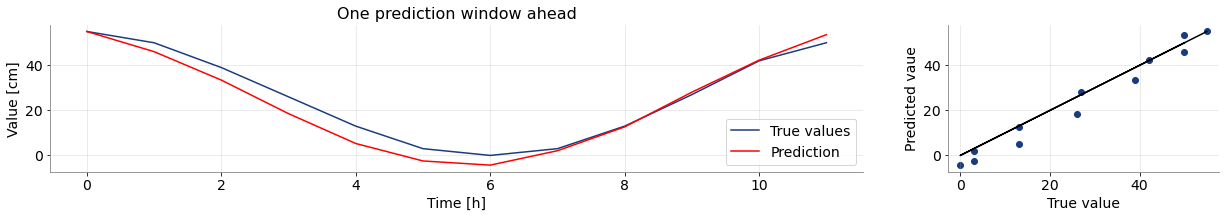

Mean squared error for first single window prediction:  18.740932630498424


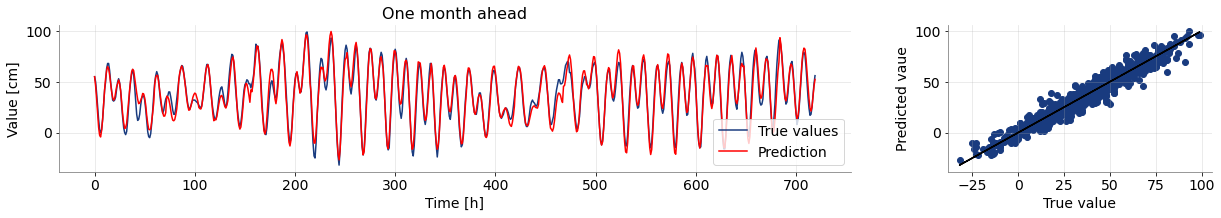

Mean squared error for one month prediction:  36.198496694096015


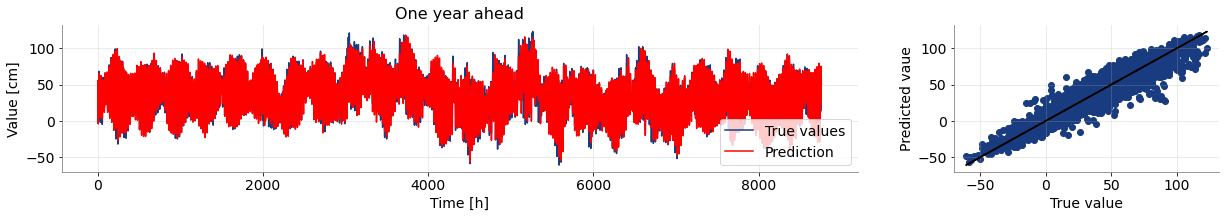

Mean squared error for one year prediction:  62.51885825539544


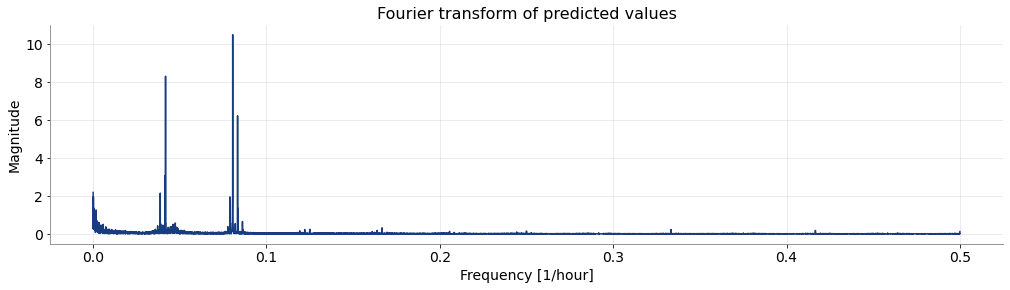

most significant periods obtained - in hours:
 [   12.41939547    23.93446602    12.            12.42330709
    24.06589384    12.41548631 39444.            25.81413613
  5634.85714286    12.65853659    12.42722117 13148.
    12.41157961  7888.8           11.96723301  1972.2
  2191.33333333  3034.15384615   580.05882353  1460.88888889
    12.43113772  2465.25         986.1         9861.        ]
- in days:
 [   0.51747481    0.99726942    0.5           0.5176378     1.00274558
    0.51731193 1643.5           1.07558901  234.78571429    0.52743902
    0.51780088  547.83333333    0.51714915  328.7           0.49863471
   82.175        91.30555556  126.42307692   24.16911765   60.87037037
    0.51796407  102.71875      41.0875      410.875     ]
indices:
 [3176 1648 3287 3175 1639 3177    1 1528    7 3116 3174    3 3178    5
 3296   20   18   13   68   27 3173   16   40    4]


In [ ]:
accuracy(scaler.inverse_transform(Y_test), scaler.inverse_transform(pred_on_true_history).flatten())

##### training the model after each prediction

In [ ]:
look_back = 48
pred_window = 12
train = np.array(df_scaled[:223512]['lvl'])
test = np.array(df_scaled[(223512-look_back):]['lvl'])

In [ ]:
windows_number = 5
pred_online = np.zeros((windows_number,pred_window))
x = np.expand_dims(test[:look_back].reshape(-1,1), axis=0)

In [ ]:
for i in range(windows_number):
    print('Step', i)
    X_train, Y_train = create_dataset1(train, look_back=look_back, pred_window=pred_window)

    model_online = Sequential()
    model_online.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_online.add(LSTM(24, return_sequences=True))
    model_online.add(LSTM(24))
    model_online.add(Dense(pred_window))
 
    model_online.compile(optimizer='adam', loss='mean_squared_error')
    model_online.fit(X_train, Y_train, batch_size=64, epochs=20)

    p = model_online.predict(x)
    x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
    pred_online[i] = p
    train = np.append(train, p)
    

Step 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/20
18622/18622 [==============================] - 22s 1ms/step - loss: 0.0271
Epoch 2/20
18622/18622 [==============================] - 22s 1ms/step - loss: 0.0086
Epoch 3/20
18622/18622 [==============================] - 21s 1ms/step - loss: 0.0052
Epoch 4/20
18622/18622 [==============================] - 22s 1ms/step - loss: 0.0049
Epoch 5/20
18622/18622 [==============================] - 22s 1ms/step - loss: 0.0048
Epoch 6/20
18622/18622 [==============================] - 22s 1ms/step - loss: 0.0046
Epoch 7/20
18622/18622 [==============================] - 21s 1ms/step - loss: 0.0046
Epoch 8/20
18622/18622 [==============================] - 21s 1ms/step - loss: 0.0045
Epoch 9/20
18622/18622 [==============================] - 21s 1ms/step - loss: 0.0044
Epoch 10/20
18622/18622 [==============================] - 21s 1ms/step - loss: 0.0043
Epoch 11/20
18622/18622 [=========================

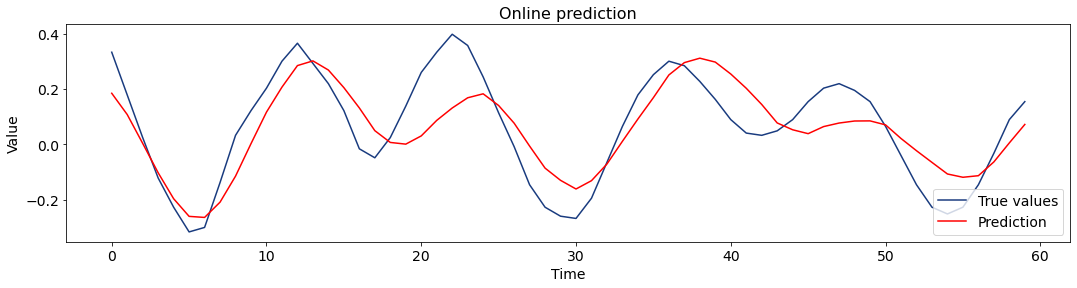

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
ax.plot(test[0:pred_window*windows_number], color='#193B7F')
ax.plot(pred_online.flatten(), color='red')
ax.set_title('Online prediction') 
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend(['True values', 'Prediction'], loc='lower right')

#### model with dropout

In [ ]:
look_back = 48
pred_window = 12
X, Y = create_dataset(np.array(df_scaled['lvl']), look_back=look_back, pred_window=pred_window)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=False)

In [ ]:
batch = 64
 
for k in range(13,50):
    model_12 = Sequential()
    model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(Dropout(0.5))
    model_12.add(LSTM(24))
    model_12.add(Dense(pred_window))
 
    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))
 
    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_dropout/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')
    

In [ ]:
predictions12_scaled_dropout = np.zeros((50,Y_test.shape[0]*Y_test.shape[1]))
for k in range(50):
    predictions12_scaled_dropout[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_dropout/{k}.csv'.format(k=k), delimiter=',')

predictions12_scaled_dropout = scaler.inverse_transform(predictions12_scaled_dropout)

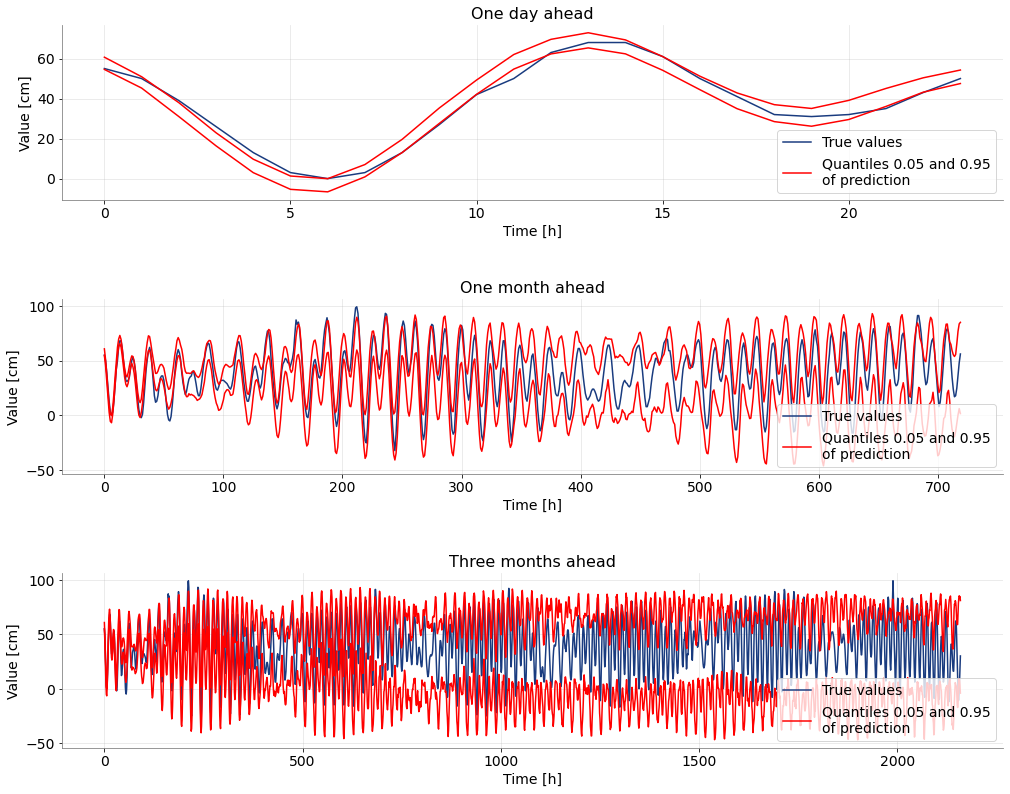

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.25
In the first 12 hours:  0.25
In the first 24 hours:  0.5
In the first 48 hours:  0.4583333333333333
For the first month:  0.8444444444444444
For the first year:  0.8392694063926941


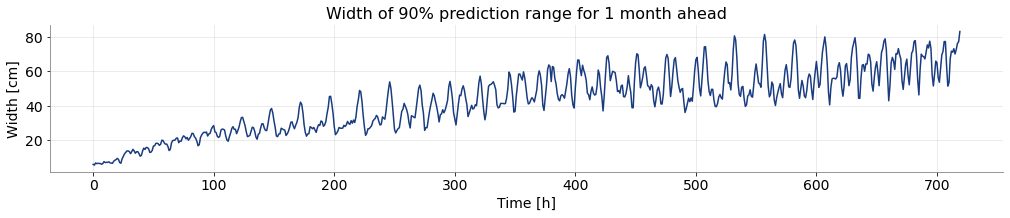

Average width of 90 % predinction range:
In the first 12 hours (prediction window):  6.675373999999994
In the first 12 hours:  6.675373999999994
In the first 24 hours:  7.218590687499997
In the first 48 hours:  10.260393499999994
For the first month:  43.085370102083324
For the first year:  79.17322875017122


In [ ]:
see_between_quantiles(scaler.inverse_transform(Y_test), predictions12_scaled_dropout, 0.95 ,'dropout')

#### model with two layers only

In [ ]:
batch = 64

for k in range(50,51):
    model_12 = Sequential()
    model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(36))
    model_12.add(Dense(pred_window))

    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.summary()
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=23, validation_data=(X_test, Y_test))

    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_a/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

In [ ]:
predictions12_scaled_a = np.zeros((50,Y_test.shape[0]*Y_test.shape[1]))
for k in range(50):
    predictions12_scaled_a[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_a/{k}.csv'.format(k=k), delimiter=',')

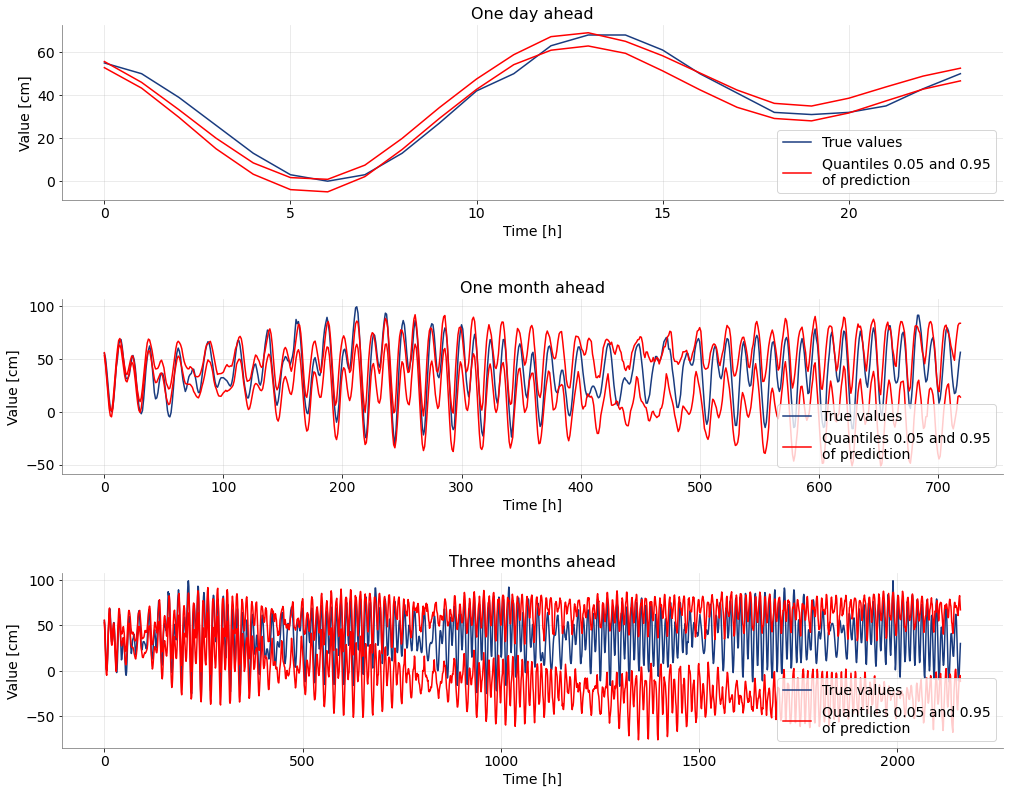

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.25
In the first 12 hours:  0.25
In the first 24 hours:  0.5
In the first 48 hours:  0.3958333333333333
For the first month:  0.825
For the first year:  0.8639269406392694


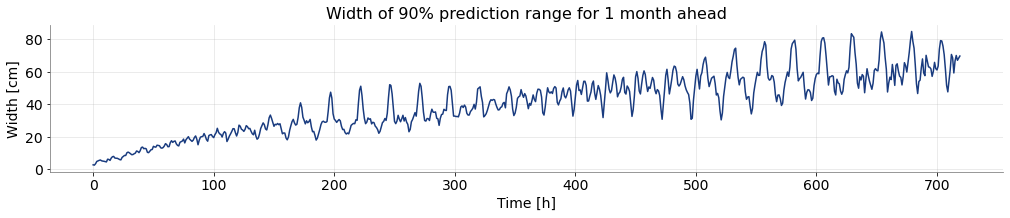

Average width of 90 % predinction range:
In the first 12 hours (prediction window):  4.639436999999998
In the first 12 hours:  4.639436999999998
In the first 24 hours:  5.660795687499996
In the first 48 hours:  8.112090874999998
For the first month:  40.80235283749998
For the first year:  90.88021796986298


In [ ]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions12_scaled_a), 0.95, '2_layers')

#### model with four layers

In [ ]:
look_back = 48
pred_window = 12
X, Y = create_dataset(np.array(df_scaled['lvl']), look_back=look_back, pred_window=pred_window)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=False)

In [ ]:
batch = 64

for k in range(40,50):
    model_12 = Sequential()
    model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(12))
    model_12.add(Dense(pred_window))

    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=25, validation_data=(X_test, Y_test))

    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_b/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

In [ ]:
predictions12_scaled_b = np.zeros((49,Y_test.shape[0]*Y_test.shape[1]))
for k in range(49):
    predictions12_scaled_b[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_b/{k}.csv'.format(k=k), delimiter=',')


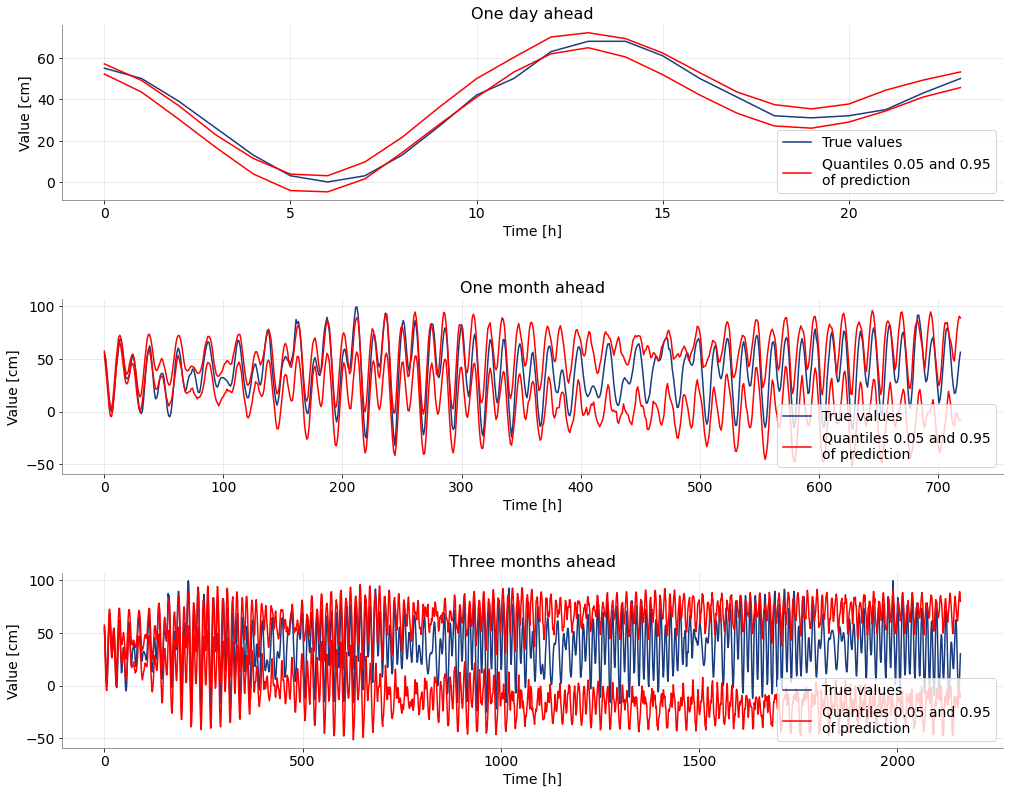

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.4166666666666667
In the first 12 hours:  0.4166666666666667
In the first 24 hours:  0.7083333333333334
In the first 48 hours:  0.5833333333333334
For the first month:  0.8680555555555556
For the first year:  0.8696347031963471


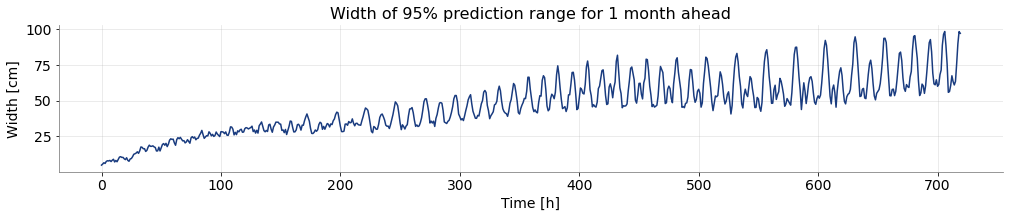

Average width of 95.0 % predinction range:
In the first 12 hours (prediction window):  7.190149499999997
In the first 12 hours:  7.190149499999997
In the first 24 hours:  8.175574249999997
In the first 48 hours:  11.637342624999995
For the first month:  46.596045241666644
For the first year:  84.25880544589039


In [ ]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions12_scaled_b), 0.95)

#### model with 5 layers

In [ ]:
look_back = 48
pred_window = 12
X, Y = create_dataset(np.array(df_scaled['lvl']), look_back=look_back, pred_window=pred_window)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=False)

In [ ]:
batch = 64

for k in range(14,50):
    model_12 = Sequential()
    model_12.add(LSTM(64, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(64, return_sequences=True))
    model_12.add(LSTM(32, return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(12))
    model_12.add(Dense(pred_window))

    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.summary()
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))

    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_c/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

In [ ]:
predictions12_scaled_c = np.zeros((46,Y_test.shape[0]*Y_test.shape[1]))
for k in range(46):
    predictions12_scaled_c[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_c/{k}.csv'.format(k=k), delimiter=',')
 

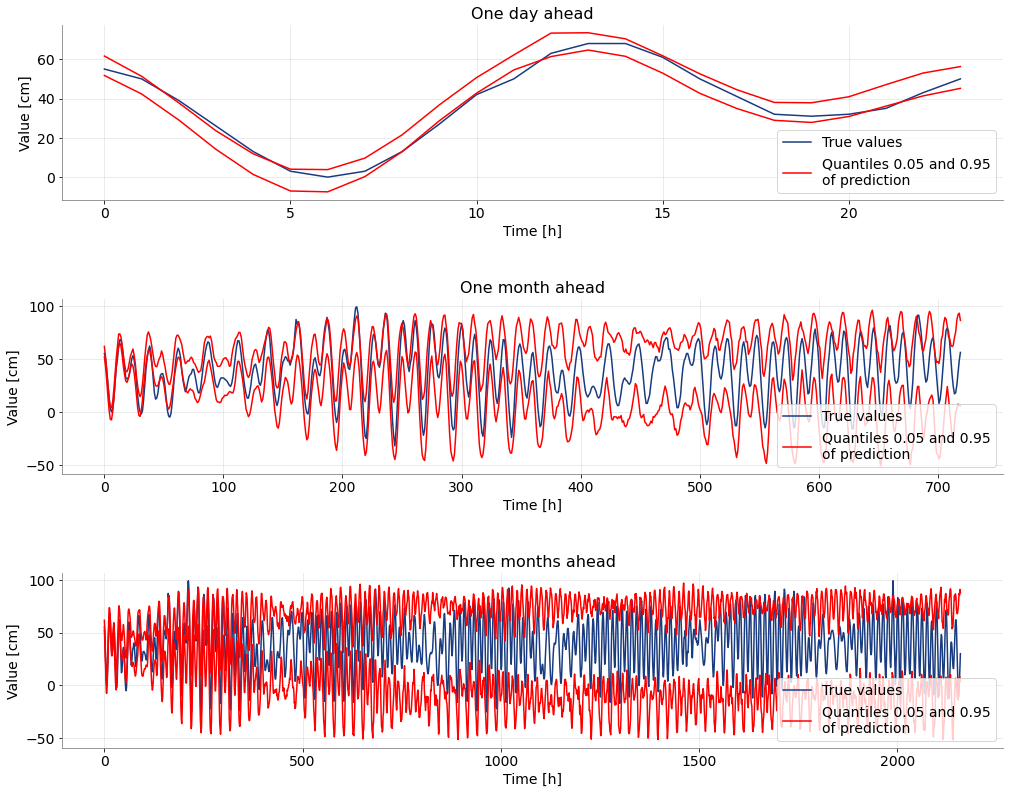

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.5
In the first 12 hours:  0.5
In the first 24 hours:  0.7083333333333334
In the first 48 hours:  0.5833333333333334
For the first month:  0.9013888888888889
For the first year:  0.8785388127853881


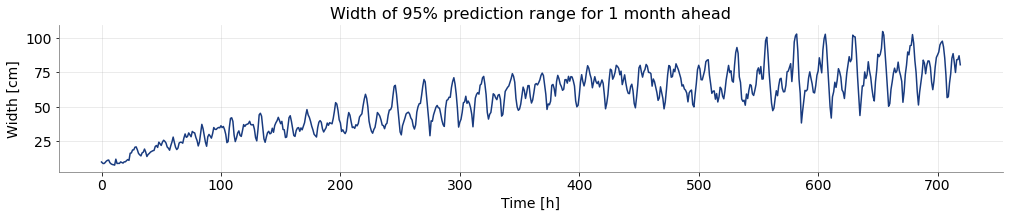

Average width of 95.0 % predinction range:
In the first 12 hours (prediction window):  9.296724375000002
In the first 12 hours:  9.296724375000002
In the first 24 hours:  9.682419062500001
In the first 48 hours:  13.706940625
For the first month:  53.98691741666666
For the first year:  85.24234676541096


In [ ]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions12_scaled_c), 0.95)

#### model with 7 layers

In [ ]:
look_back = 48
pred_window = 12
X, Y = create_dataset(np.array(df_scaled['lvl']), look_back=look_back, pred_window=pred_window)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=False)

In [ ]:
# to calculate number of parameters in LSTM layer
n = 96   # number of cells and size of the history h_{t-1}
m = 1    # size of the input x_t
4 * (n * (n + m + 1))

37632

In [ ]:
batch = 64

for k in range(34,50):
    model_12 = Sequential()
    model_12.add(LSTM(96, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(64, return_sequences=True))
    model_12.add(LSTM(64, return_sequences=True))
    model_12.add(LSTM(32, return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(12))
    model_12.add(Dense(pred_window))

    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.summary()
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=25, validation_data=(X_test, Y_test))

    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_d/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

In [ ]:
predictions12_scaled_d = np.zeros((50,Y_test.shape[0]*Y_test.shape[1]))
for k in range(50):
    predictions12_scaled_d[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_d/{k}.csv'.format(k=k), delimiter=',')
 

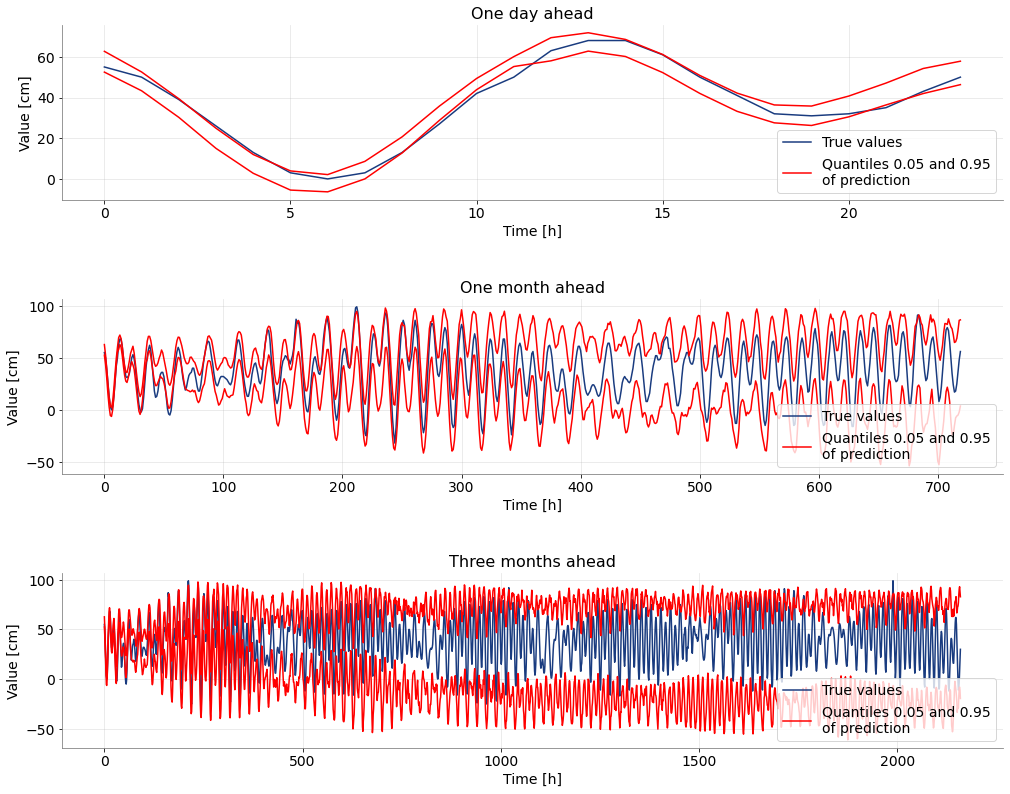

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.5833333333333334
In the first 12 hours:  0.5833333333333334
In the first 24 hours:  0.75
In the first 48 hours:  0.6458333333333334
For the first month:  0.9263888888888889
For the first year:  0.9269406392694064


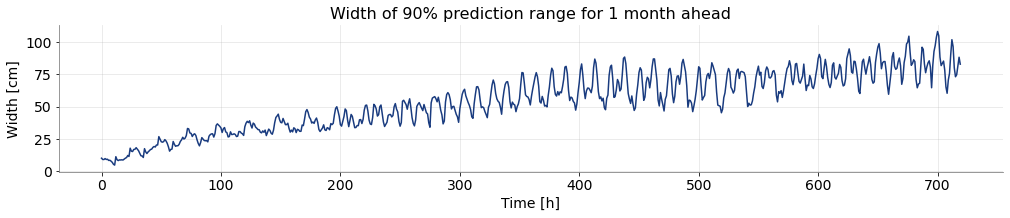

Average width of 90 % predinction range:
In the first 12 hours (prediction window):  8.294253875
In the first 12 hours:  8.294253875
In the first 24 hours:  9.087134937499998
In the first 48 hours:  12.708110156249996
For the first month:  54.218720227083324
For the first year:  98.49713340188354


In [ ]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions12_scaled_d), 0.95, '8_layers')

### Predict only one future observation (3 layer nn)


In [ ]:
look_back = 12
pred_window = 1
train = df_scaled[:223512+pred_window]
test = df_scaled[(223512-look_back):]
X_train, Y_train = create_dataset(np.array(train['lvl']), look_back=look_back, pred_window=pred_window)
X_test, Y_test = create_dataset(np.array(test['lvl']), look_back=look_back, pred_window=pred_window)

In [ ]:
# first checking optimal number of epochs

batch = 128   # larger batch to make it faster

model_1 = Sequential()
model_1.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
model_1.add(LSTM(24, return_sequences=True))
model_1.add(LSTM(24))
model_1.add(Dense(pred_window))

model_1.compile(optimizer='adam', loss='mean_squared_error')
model_1.fit(X_train, Y_train, batch_size=batch, epochs=100, validation_data=(X_test, Y_test))


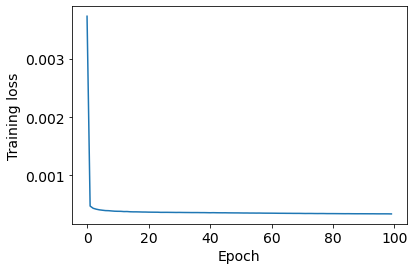

In [ ]:
plt.plot(model_1.history.history['loss'])
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.show()

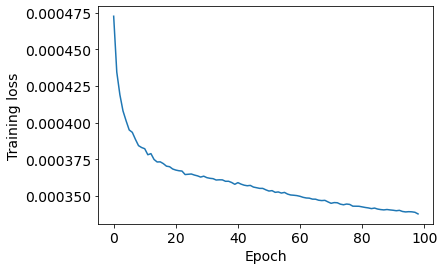

In [ ]:
plt.plot(model_1.history.history['loss'][1:])
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
batch = 128

for k in range(0,50):
    model_1 = Sequential()
    model_1.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_1.add(LSTM(24, return_sequences=True))
    model_1.add(LSTM(24))
    model_1.add(Dense(pred_window))

    model_1.compile(optimizer='adam', loss='mean_squared_error')
    model_1.fit(X_train, Y_train, batch_size=batch, epochs=25, validation_data=(X_test, Y_test))

    pred_1 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_1.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_1 = np.append(pred_1, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window1_scaled_new/{k}.csv'.format(k=k), pred_1, delimiter=',', fmt='%10.5f')

In [ ]:
predictions1_scaled = np.zeros((27,Y_test.shape[0]*Y_test.shape[1]))
for k in range(27):
    predictions1_scaled[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window1_scaled_new/{k}.csv'.format(k=k), delimiter=',')


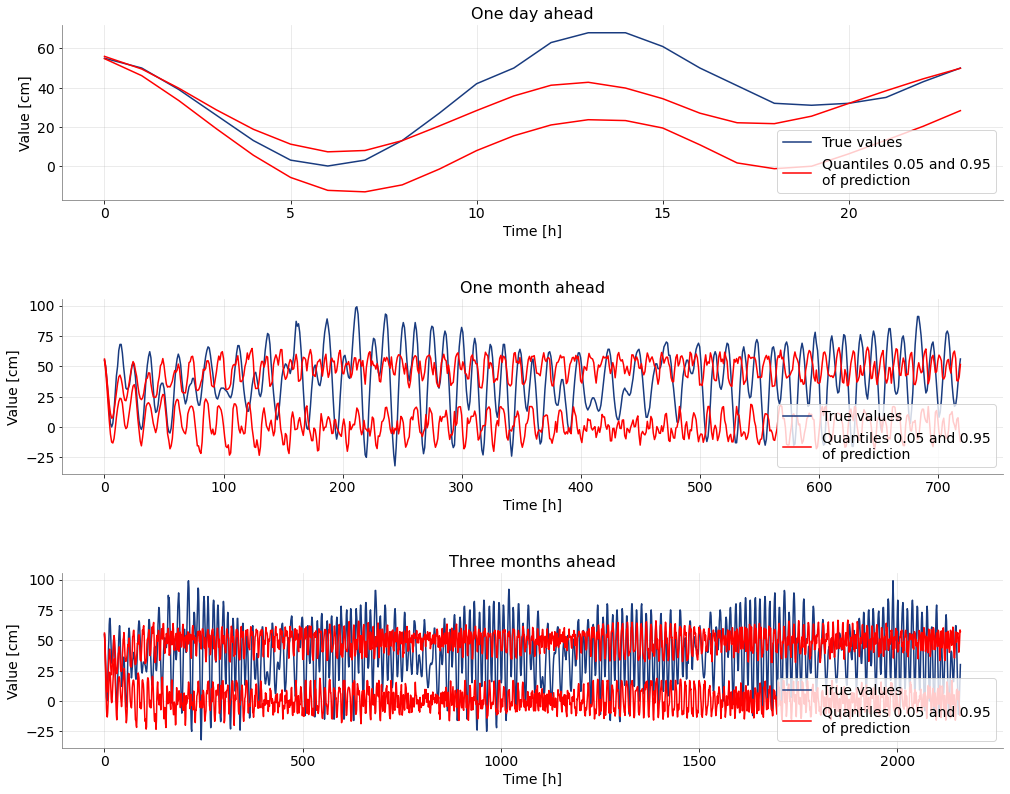

What part of real values lies between quantile lines:
In the first 1 hours (prediction window):  1.0
In the first 12 hours:  0.5833333333333334
In the first 24 hours:  0.375
In the first 48 hours:  0.5416666666666666
For the first month:  0.48333333333333334
For the first year:  0.5679223744292238


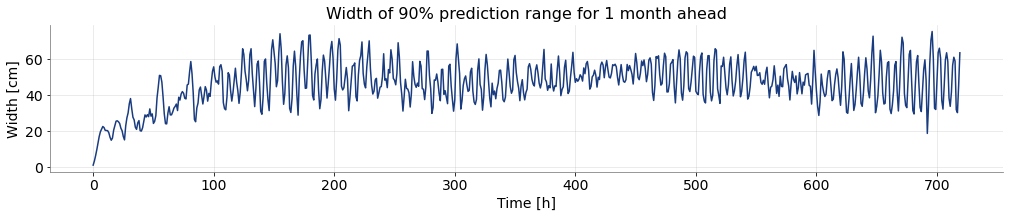

Average width of 90 % predinction range:
In the first 1 hours (prediction window):  1.1676390000000012
In the first 12 hours:  14.734825999999998
In the first 24 hours:  17.903700624999995
In the first 48 hours:  21.866642749999997
For the first month:  46.40751357499999
For the first year:  48.757436058904105


In [ ]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions1_scaled), 0.95, '1pred_win')

### window independent from seasonality (3 layer nn)


In [ ]:
look_back = 4*8
pred_window = 8
train = df_scaled[:223512+pred_window]
test = df_scaled[(223512-look_back):]
X_train, Y_train = create_dataset(np.array(train['lvl']), look_back=look_back, pred_window=pred_window)
X_test, Y_test = create_dataset(np.array(test['lvl']), look_back=look_back, pred_window=pred_window)

In [ ]:
batch = 64
 
for k in range(1,50):
    model_15 = Sequential()
    model_15.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_15.add(LSTM(24, return_sequences=True))
    model_15.add(LSTM(24))
    model_15.add(Dense(pred_window))
 
    model_15.compile(optimizer='adam', loss='mean_squared_error')
    model_15.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))
 
    pred_15 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_15.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_15 = np.append(pred_15, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window8_scaled/{k}.csv'.format(k=k), pred_15, delimiter=',', fmt='%10.5f')

In [ ]:
predictions8_scaled = np.zeros((30,Y_test.shape[0]*Y_test.shape[1]))
for k in range(30):
    predictions8_scaled[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window8_scaled/{k}.csv'.format(k=k), delimiter=',')


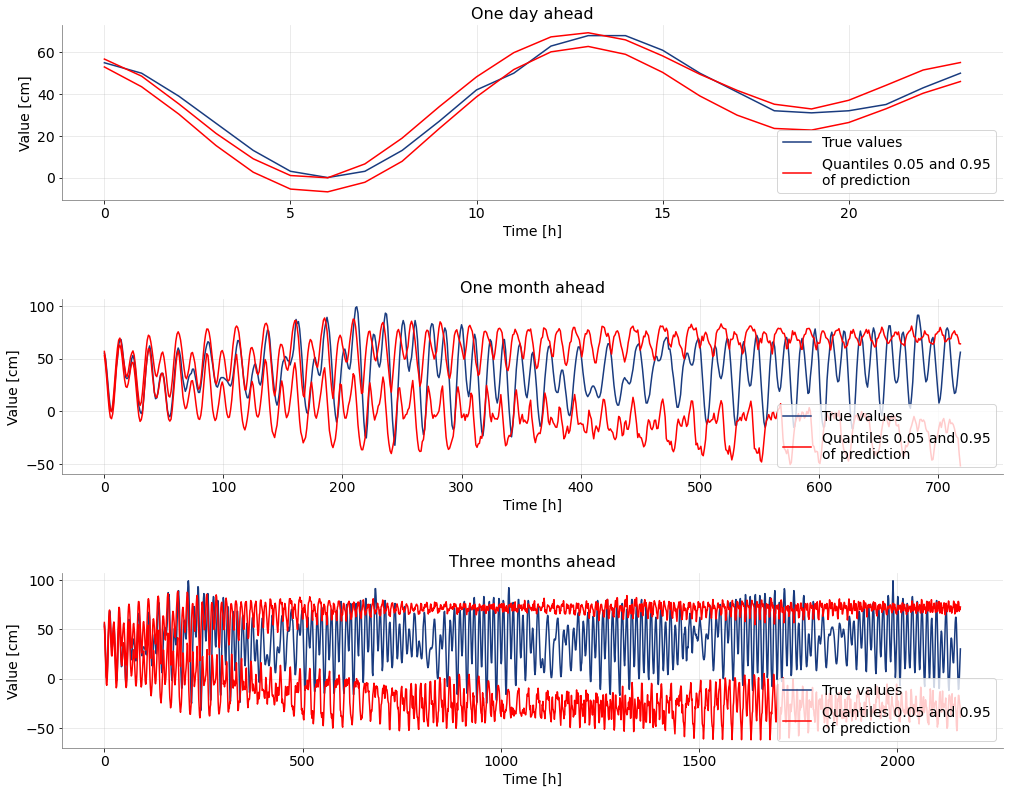

What part of real values lies between quantile lines:
In the first 8 hours (prediction window):  0.25
In the first 12 hours:  0.4166666666666667
In the first 24 hours:  0.5833333333333334
In the first 48 hours:  0.7083333333333334
For the first month:  0.7555555555555555
For the first year:  0.866324200913242


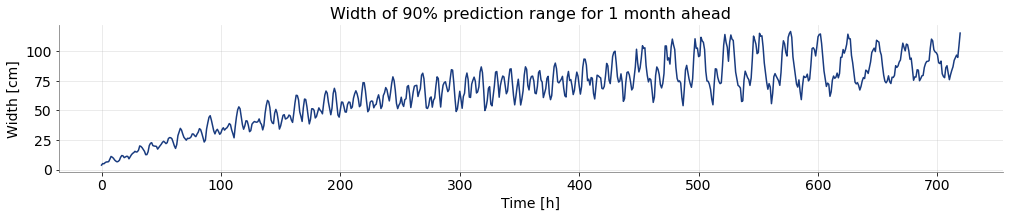

Average width of 90 % predinction range:
In the first 8 hours (prediction window):  6.0015774375
In the first 12 hours:  7.271252624999999
In the first 24 hours:  8.412974499999997
In the first 48 hours:  12.660041499999997
For the first month:  65.99414854583331
For the first year:  96.77872314143833


In [ ]:
see_between_quantiles(scaler.inverse_transform(Y_test), scaler.inverse_transform(predictions8_scaled), 0.95, '8pred_win')

### bigger look back window


In [ ]:
look_back = 360
pred_window = 12
train = df_scaled[:223512+pred_window]
test = df_scaled[(223512-look_back):]
X_train, Y_train = create_dataset(np.array(train['lvl']), look_back=look_back, pred_window=pred_window)
X_test, Y_test = create_dataset(np.array(test['lvl']), look_back=look_back, pred_window=pred_window)

In [ ]:
batch = 64
 
for k in range(44,50):
    model_12 = Sequential()
    model_12.add(LSTM(48, input_shape=(look_back,1), return_sequences=True))
    model_12.add(LSTM(24, return_sequences=True))
    model_12.add(LSTM(24))
    model_12.add(Dense(pred_window))
 
    model_12.compile(optimizer='adam', loss='mean_squared_error')
    model_12.summary()
    model_12.fit(X_train, Y_train, batch_size=batch, epochs=20, validation_data=(X_test, Y_test))
 
    pred_12 = []
    x = X_test[[0]]
    for i in range(len(Y_test)):
        p = model_12.predict(x)
        x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
        pred_12 = np.append(pred_12, p)
    
    np.savetxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_biggerlookback/{k}.csv'.format(k=k), pred_12, delimiter=',', fmt='%10.5f')

In [ ]:
predictions12_scaled = np.zeros((44,Y_test.shape[0]*Y_test.shape[1]))
for k in range(44):
    predictions12_scaled[k] = np.genfromtxt('/content/drive/My Drive/__MGR/predictions_window12_scaled_biggerlookback/{k}.csv'.format(k=k), delimiter=',')
predictions12_scaled = scaler.inverse_transform(predictions12_scaled)

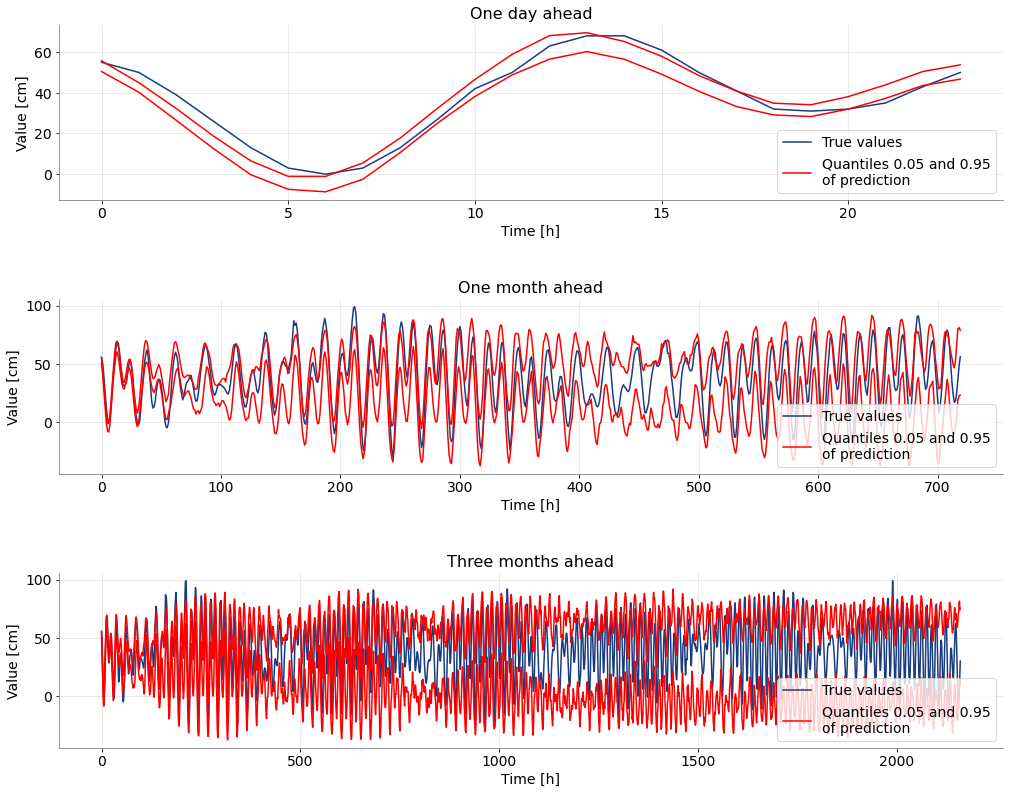

What part of real values lies between quantile lines:
In the first 12 hours (prediction window):  0.5
In the first 12 hours:  0.5
In the first 24 hours:  0.5
In the first 48 hours:  0.5
For the first month:  0.7861111111111111
For the first year:  0.8123287671232877


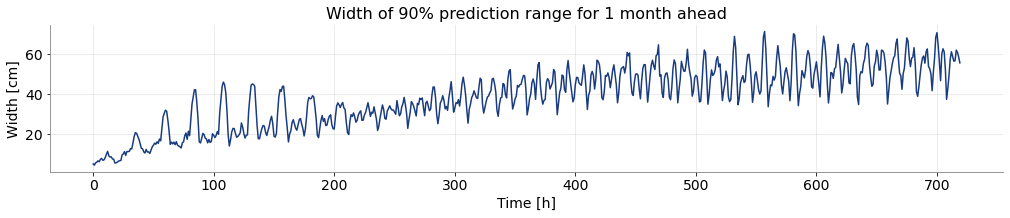

Average width of 90 % predinction range:
In the first 12 hours (prediction window):  6.969164624999999
In the first 12 hours:  6.969164624999999
In the first 24 hours:  7.3195583125
In the first 48 hours:  10.3824325625
For the first month:  38.950000768749995
For the first year:  69.8064464255137


In [ ]:
see_between_quantiles(scaler.inverse_transform(Y_test), predictions12_scaled, 0.95, '360look_back')

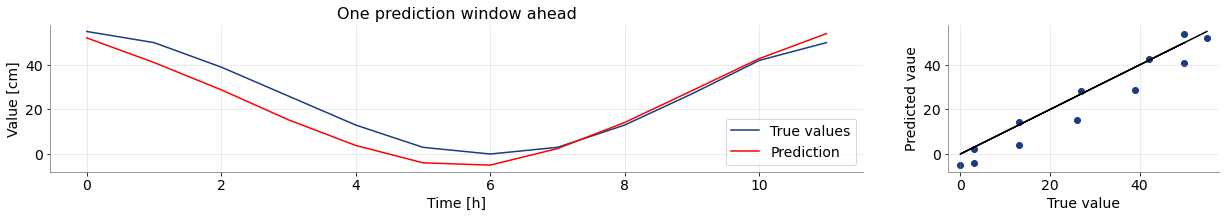

Mean squared error for first single window prediction:  40.24307805332508


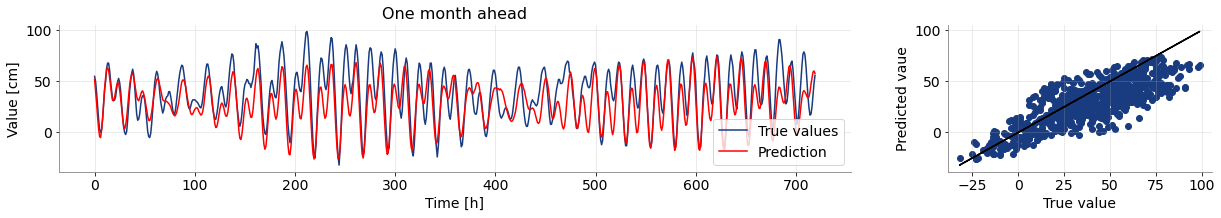

Mean squared error for one month prediction:  326.7582311758959


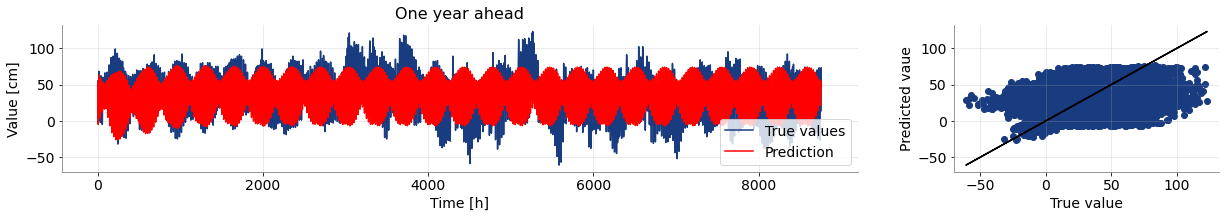

Mean squared error for one year prediction:  891.8540513036343


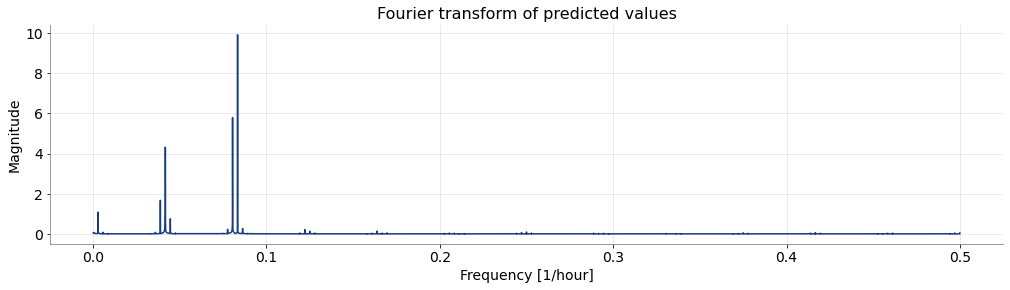

most significant periods obtained - in hours:
 [ 12.          12.43113772  24.00730371  23.99270073  12.42722117
  25.78039216  24.02192448  12.43505675  23.9781155  346.
  12.42330709  24.03656307  12.43897824  22.44963005  24.05121951
  23.963548    12.41939547  24.06589384  12.44290221  24.08058608
 349.0619469   23.94899818  12.41548631  12.44682865]
- in days:
 [ 0.5         0.51796407  1.00030432  0.99969586  0.51780088  1.07418301
  1.00091352  0.51812736  0.99908815 14.41666667  0.5176378   1.00152346
  0.51829076  0.93540125  1.00213415  0.99848117  0.51747481  1.00274558
  0.51845426  1.00335775 14.54424779  0.99787492  0.51731193  0.51861786]
indices:
 [3287 3173 1643 1644 3174 1530 1642 3172 1645  114 3175 1641 3171 1757
 1640 1646 3176 1639 3170 1638  113 1647 3177 3169]


In [ ]:
accuracy(scaler.inverse_transform(Y_test), predictions12_scaled[4])

One trial with much more complex network for 360 look back

In [ ]:
batch = 64

model_12 = Sequential()
model_12.add(LSTM(96, input_shape=(look_back,1), return_sequences=True))
model_12.add(LSTM(64, return_sequences=True))
model_12.add(LSTM(64, return_sequences=True))
model_12.add(LSTM(32, return_sequences=True))
model_12.add(LSTM(24, return_sequences=True))
model_12.add(LSTM(24, return_sequences=True))
model_12.add(LSTM(12))
model_12.add(Dense(pred_window))

model_12.compile(optimizer='adam', loss='mean_squared_error')
model_12.summary()
model_12.fit(X_train, Y_train, batch_size=batch, epochs=10, validation_data=(X_test, Y_test))

pred_12 = []
x = X_test[[0]]
for i in range(len(Y_test)):
    p = model_12.predict(x)
    x = np.expand_dims(np.append(x[0][pred_window:], p.reshape(-1,1), axis=0), axis=0)
    pred_12 = np.append(pred_12, p)

np.savetxt('/content/drive/My Drive/__MGR/most_complex_model.csv', pred_12, delimiter=',', fmt='%10.5f')

In [ ]:
predictions12_complex = np.zeros((1,Y_test.shape[0]*Y_test.shape[1]))
for k in range(1):
    predictions12_complex[k] = np.genfromtxt('/content/drive/My Drive/__MGR/most_complex_model.csv', delimiter=',')
predictions12_complex = scaler.inverse_transform(predictions12_complex)

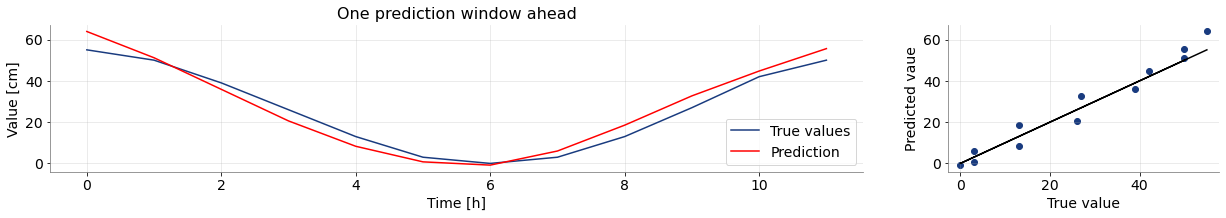

Mean squared error for first single window prediction:  21.538800243524943


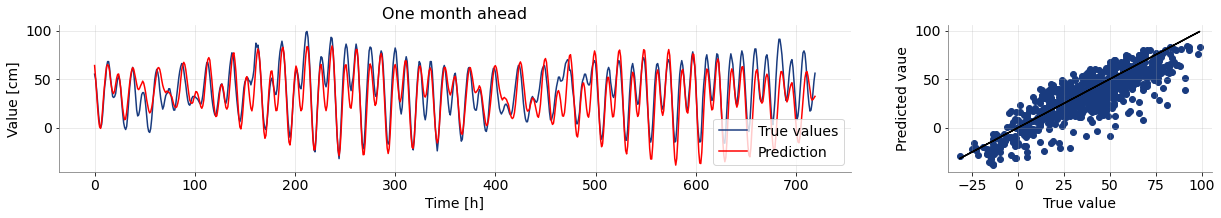

Mean squared error for one month prediction:  230.89420954798916


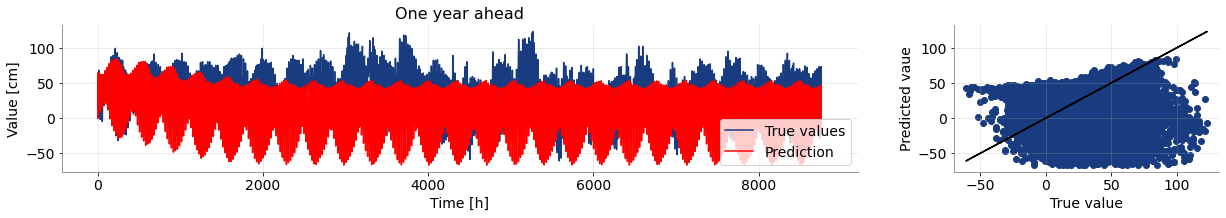

Mean squared error for one year prediction:  2413.24623744301


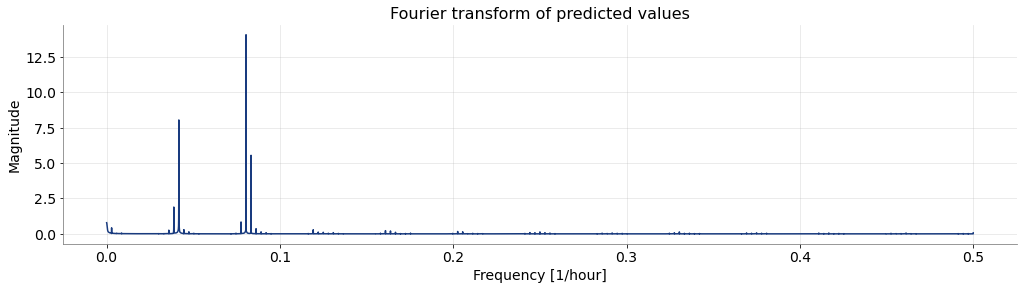

most significant periods obtained - in hours:
 [   23.99270073    24.00730371            inf    12.
    23.9781155     24.02192448    25.79725311    23.963548
    24.03656307    25.78039216    23.94899818    24.05121951
    12.43505675    23.93446602    12.89440994    24.06589384
    23.91995149 39444.         19722.         13148.
  9861.          7888.8           12.42722117  6574.        ]
- in days:
 [   0.99969586    1.00030432           inf    0.5           0.99908815
    1.00091352    1.07488555    0.99848117    1.00152346    1.07418301
    0.99787492    1.00213415    0.51812736    0.99726942    0.53726708
    1.00274558    0.99666465 1643.5         821.75        547.83333333
  410.875       328.7           0.51780088  273.91666667]
indices:
 [1644 1643    0 3287 1645 1642 1529 1646 1641 1530 1647 1640 3172 1648
 3059 1639 1649    1    2    3    4    5 3174    6]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
accuracy(scaler.inverse_transform(Y_test), predictions12_complex[0])

## SARIMA fit


In [ ]:
import itertools
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
y = df[(223512-720):223512]  # training data of length of one month 

In [ ]:
# just to choose optimal parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except: 
            continue

In [ ]:
# trying to fit model to the history of length of one month
y = df[(223512-24*30):223512]
mod = sm.tsa.statespace.SARIMAX(y, order=(2,1,2), seasonal_order=(2,1,2,12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


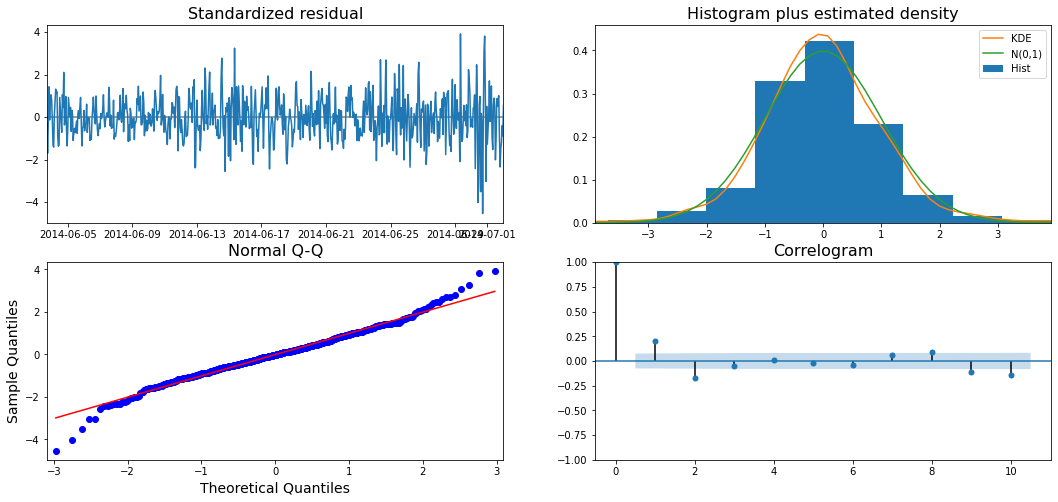

In [ ]:
results.plot_diagnostics(figsize=(18, 8))
fig.tight_layout(pad=3.0)
plt.savefig('/content/drive/My Drive/__MGR/diagnostics_sarima30days.pdf')
plt.show()

In [ ]:
forecast_window = 24 * 365
pred = results.get_forecast(forecast_window)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(0.1)

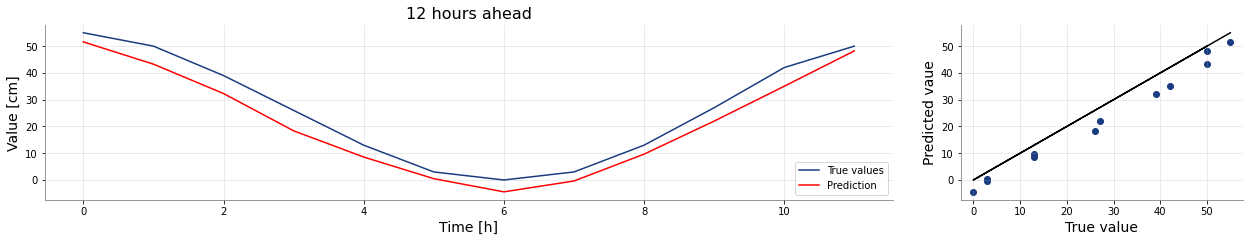

Mean squared error for first single window prediction:  25.448043050810227


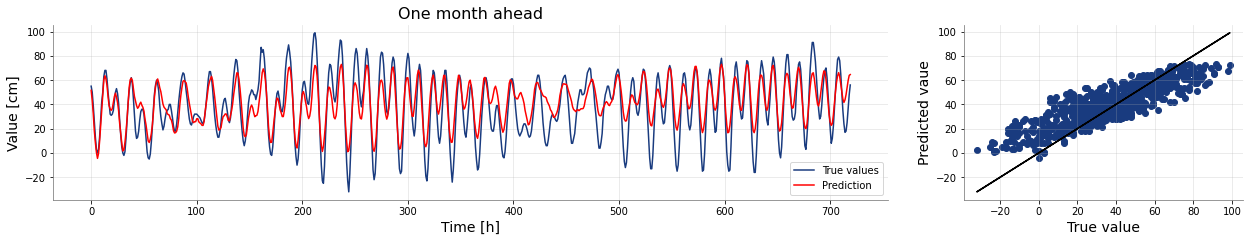

Mean squared error for one month prediction:  213.7042158414908


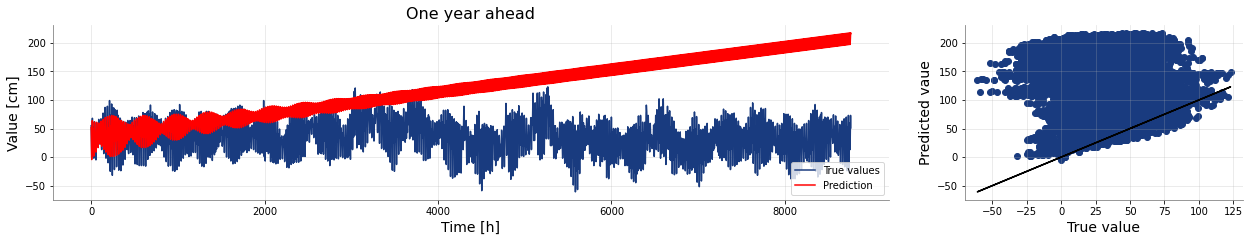

Mean squared error for one year prediction:  10878.172161426412


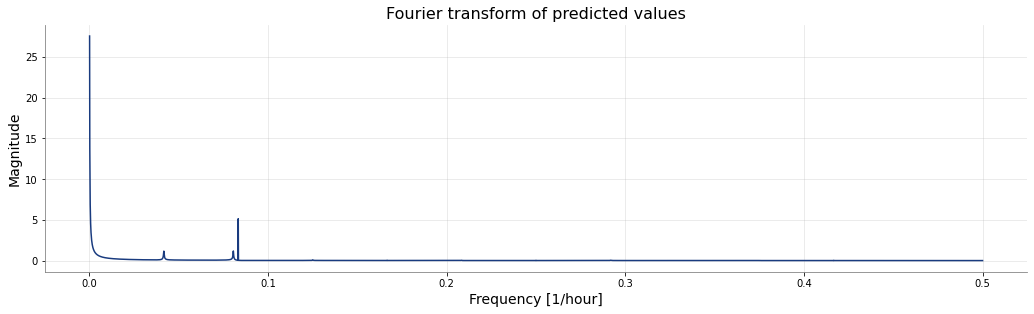

most significant periods obtained - in hours:
 [8760.         4380.         2920.         2190.         1752.
   12.         1460.         1251.42857143 1095.          973.33333333
  876.          796.36363636  730.          673.84615385  625.71428571
  584.          547.5         515.29411765  486.66666667  461.05263158
  438.          417.14285714  398.18181818  380.86956522]
- in days:
 [365.         182.5        121.66666667  91.25        73.
   0.5         60.83333333  52.14285714  45.625       40.55555556
  36.5         33.18181818  30.41666667  28.07692308  26.07142857
  24.33333333  22.8125      21.47058824  20.27777778  19.21052632
  18.25        17.38095238  16.59090909  15.86956522]
indices:
 [  1   2   3   4   5 730   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23]


In [ ]:
accuracy(np.array(df[223512:(223512+forecast_window)]['lvl']).reshape(-1,12), np.array(pred_mean))

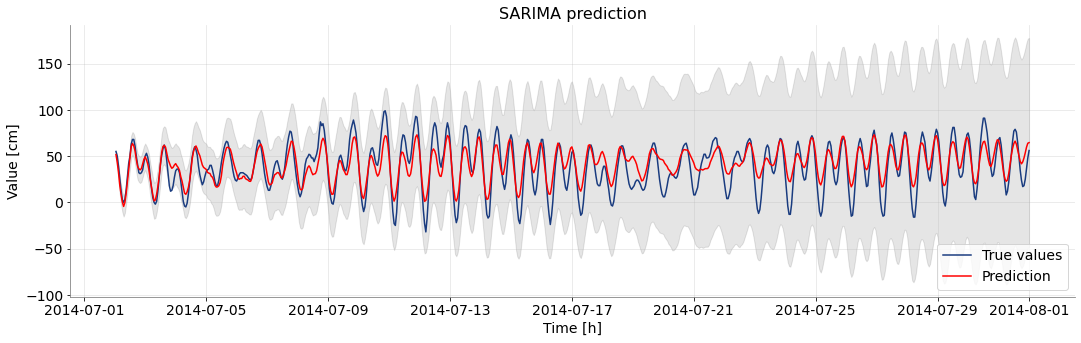

In [ ]:
# prediction and its confidence interval
plot_window = 720
fig, ax = plt.subplots(1,1, figsize=(18,5))
ax.plot(df[223512:(223512+plot_window)], color='#193B7F')
ax.plot(pred_mean[:plot_window], color='red')
ax.fill_between(pred_ci.index[:plot_window],
                pred_ci.iloc[:plot_window, 0],
                pred_ci.iloc[:plot_window, 1], color='k', alpha=.1)
ax.set_title('SARIMA prediction') 
ax.set_xlabel('Time [h]')
ax.set_ylabel('Value [cm]')
ax.legend(['True values', 'Prediction'], loc='lower right')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
plt.savefig('/content/drive/My Drive/__MGR/sarima_ci.pdf')
plt.show()

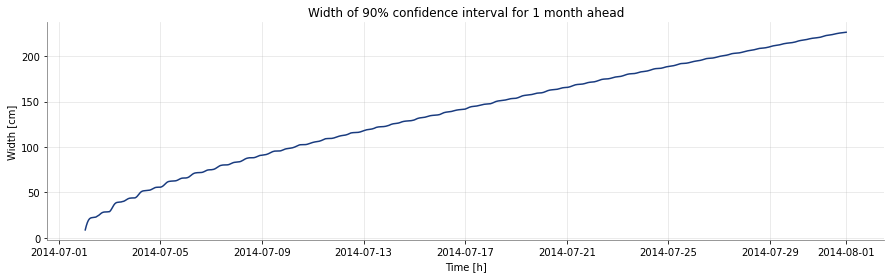

Average width of 90% conficence interval:
In the first 12 hours:  19.596399739772078
In the first 24 hours:  23.48395070997815
In the first 48 hours:  31.651599678417252
For the first month:  138.07201576695303


In [ ]:
ci_width = pred_ci.iloc[:720, 1] - pred_ci.iloc[:720, 0]
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    
ax.plot(ci_width, color='#193B7F')
ax.set_title('Width of 90% confidence interval for 1 month ahead')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Width [cm]')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color(None)
ax.spines['left'].set_color('0.5')
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
plt.show()

print('Average width of 90% conficence interval:')
end = 12
print('In the first 12 hours: ', np.mean(ci_width[:end]))
end = 24
print('In the first 24 hours: ', np.mean(ci_width[:end]))
end = 48
print('In the first 48 hours: ', np.mean(ci_width[:end]))
end = 720
print('For the first month: ', np.mean(ci_width[:end]))


One year history


In [ ]:
# best params: (2,1,2), (2,1,2) 12

# trying to fit model to the history of length of one year
y = df[(223512-24*365):223512]
mod = sm.tsa.statespace.SARIMAX(y, order=(2,1,2), seasonal_order=(2,1,2,12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
results.aic

39184.056652530155

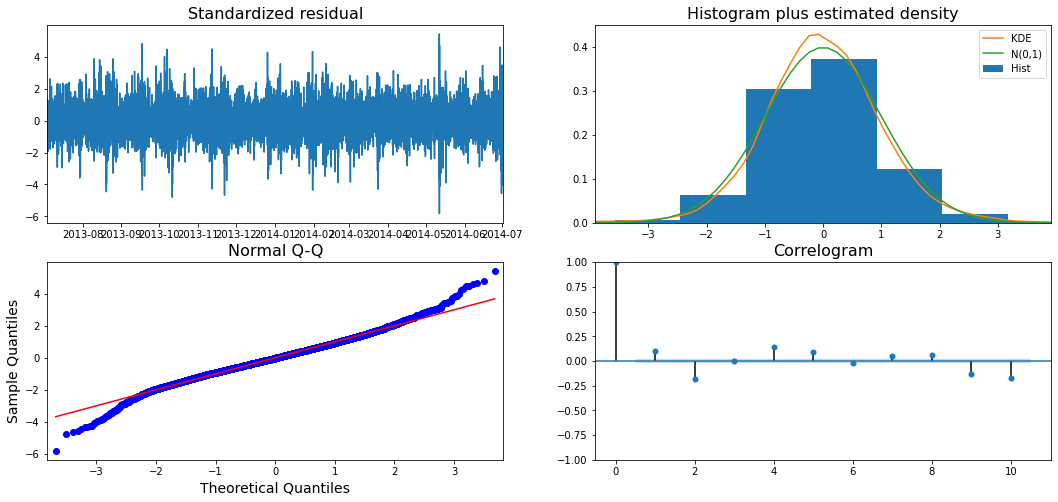

In [ ]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
forecast_window = 24 * 365
pred = results.get_forecast(forecast_window)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

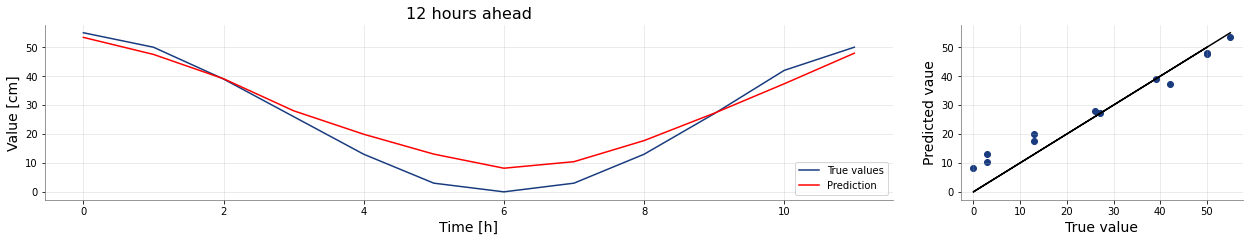

Mean squared error for first single window prediction:  27.630665836409563


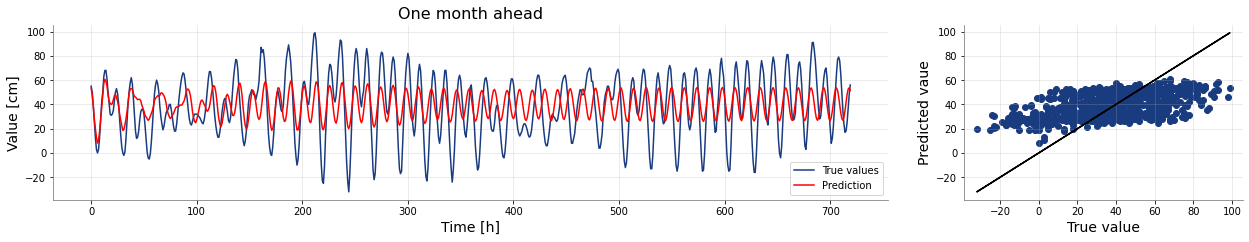

Mean squared error for one month prediction:  480.27343213245007


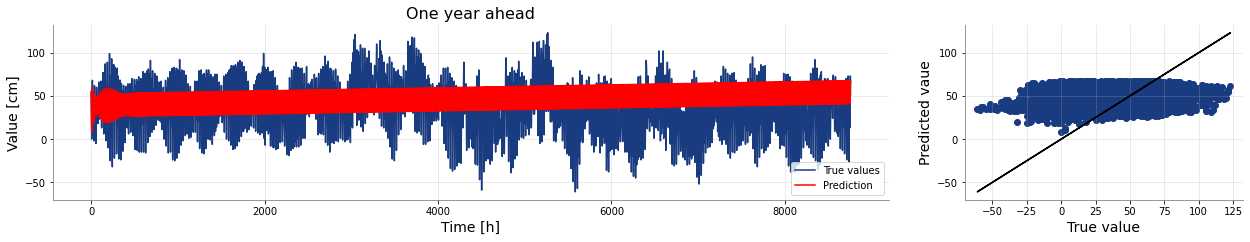

Mean squared error for one year prediction:  859.4855836991618


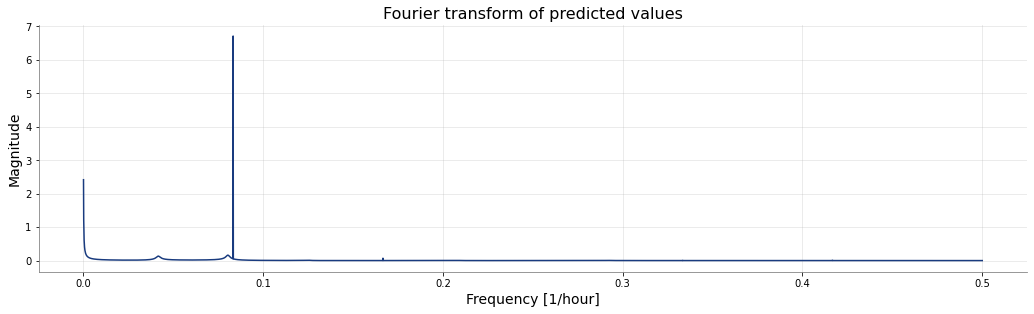

most significant periods obtained - in hours:
 [  12.         8760.         4380.         2920.         2190.
 1752.         1460.         1251.42857143 1095.          973.33333333
  876.          796.36363636  730.          673.84615385  625.71428571
   12.44318182   12.42553191  584.           12.46088193   12.40793201
   12.47863248   12.3903819    12.49643367   12.37288136]
- in days:
 [  0.5        365.         182.5        121.66666667  91.25
  73.          60.83333333  52.14285714  45.625       40.55555556
  36.5         33.18181818  30.41666667  28.07692308  26.07142857
   0.51846591   0.5177305   24.33333333   0.51920341   0.51699717
   0.51994302   0.51626591   0.52068474   0.51553672]
indices:
 [730   1   2   3   4   5   6   7   8   9  10  11  12  13  14 704 705  15
 703 706 702 707 701 708]


In [ ]:
accuracy(np.array(df[223512:(223512+forecast_window)]['lvl']).reshape(-1,12), np.array(pred_mean))

In [ ]:
# trying to fit more complex model to the history of length of one year
y = df[(223512-24*365):223512]
mod = sm.tsa.statespace.SARIMAX(y, order=(4,1,3), seasonal_order=(4,1,3,12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
results.aic

38956.632050525

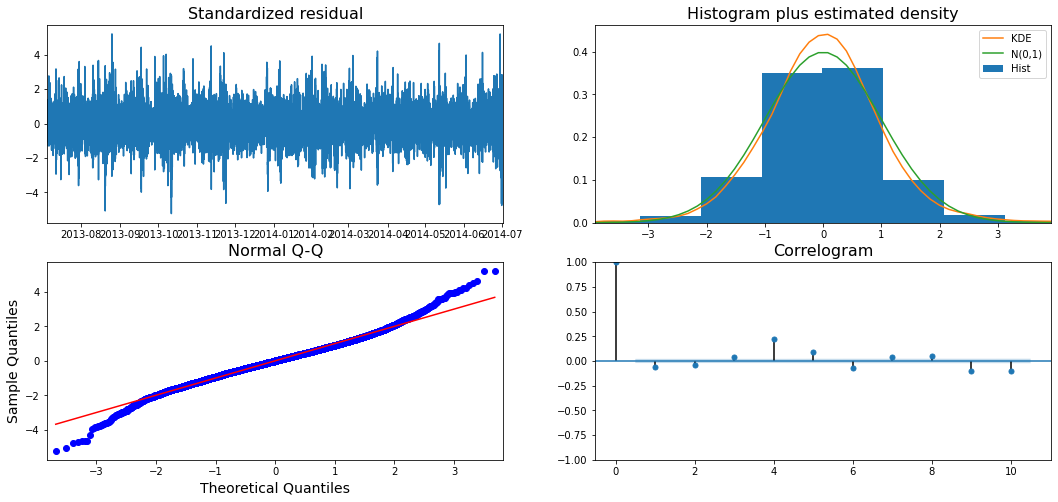

In [ ]:
results.plot_diagnostics(figsize=(18, 8))
fig.tight_layout(pad=3.0)
plt.savefig('/content/drive/My Drive/__MGR/diagnostics_sarima365days.pdf')
plt.show()

In [ ]:
forecast_window = 24 * 365
pred = results.get_forecast(forecast_window)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

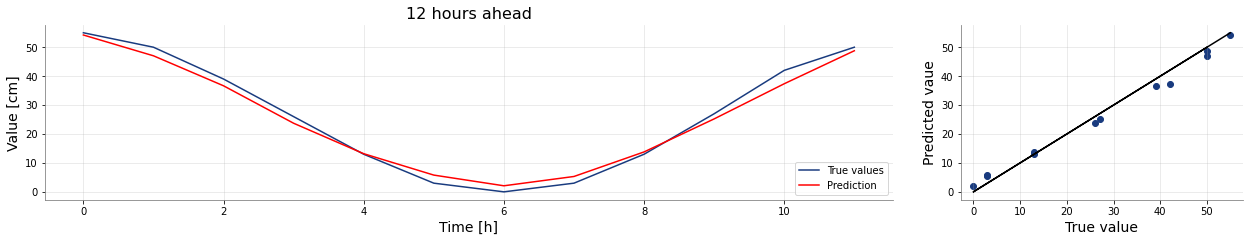

Mean squared error for first single window prediction:  5.364568946112999


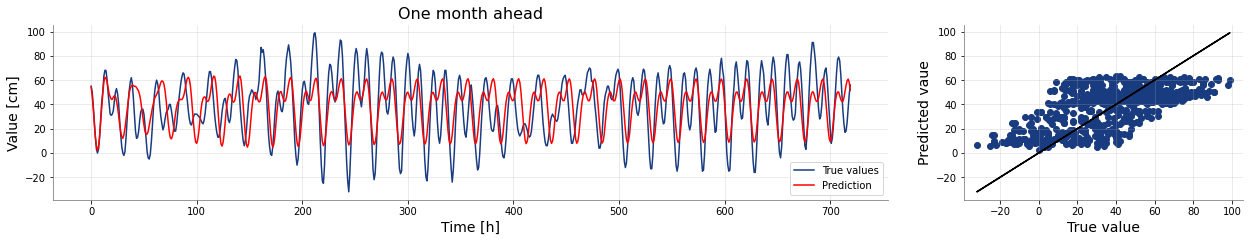

Mean squared error for one month prediction:  392.1569515797249


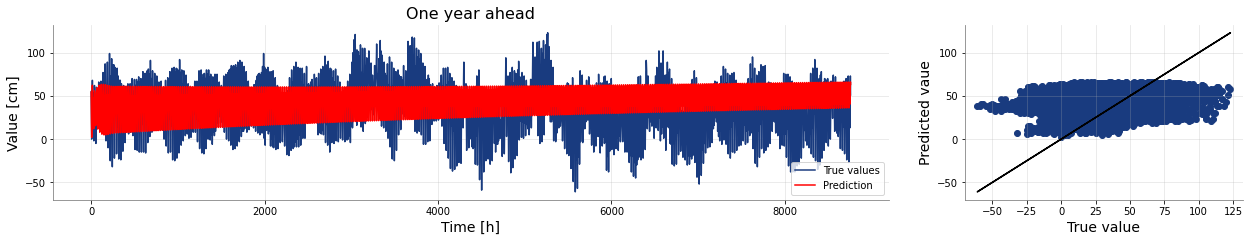

Mean squared error for one year prediction:  855.6166112206117


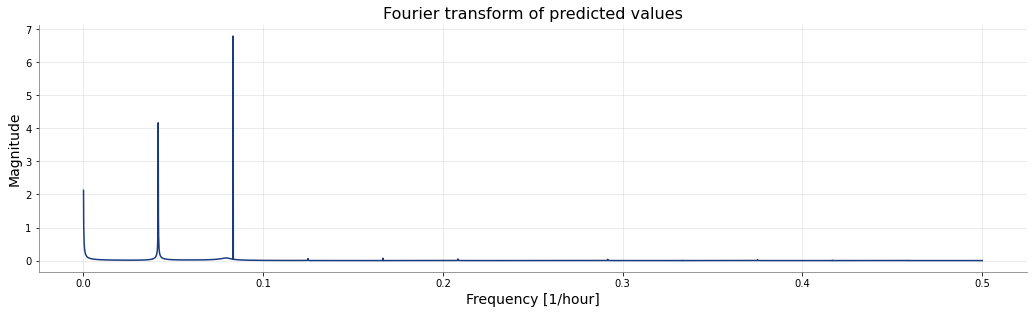

most significant periods obtained - in hours:
 [  12.           24.         8760.           23.93442623   24.06593407
 4380.           23.86920981   24.1322314  2920.         2190.
   23.80434783   24.19889503 1752.           23.7398374    24.26592798
 1460.         1251.42857143   23.67567568   24.33333333 1095.
   23.61185984   24.40111421  973.33333333  876.        ]
- in days:
 [  0.5          1.         365.           0.99726776   1.00274725
 182.5          0.99455041   1.00550964 121.66666667  91.25
   0.99184783   1.00828729  73.           0.98915989   1.01108033
  60.83333333  52.14285714   0.98648649   1.01388889  45.625
   0.98382749   1.01671309  40.55555556  36.5       ]
indices:
 [730 365   1 366 364   2 367 363   3   4 368 362   5 369 361   6   7 370
 360   8 371 359   9  10]


In [ ]:
accuracy(np.array(df[223512:(223512+forecast_window)]['lvl']).reshape(-1,12), np.array(pred_mean))